# Opis projektu i zbioru danych
W ramach projektu analizowany jest zbiór danych *World Happiness Report 2021* (Raport Szczęścia Świata 2021) dostępny na portalu Kaggle. Jest to zbiór dotyczący globalnych wyników szczęścia — czyli poziomu zadowolenia mieszkańców różnych krajów świata. Dane obejmują wyniki dla 149 krajów i zostały rozszerzone o informacje o regionach geograficznych.

Źródłem danych są coroczne raporty ONZ – *World Happiness Report*, przygotowywane we współpracy z instytutem **Gallupa** oraz **Sustainable Development Solutions Network**, oparte głównie na ankietach oceniających dobrostan i satysfakcję z życia w latach 2005–2020.

Główną analizowaną zmienną zależną jest **Life Ladder**, która określa poziom szczęścia mieszkańców danego kraju.

**Wybrane zmienne do analizy:**
* country – kraj
* region – region świata
* gdp_per_capita – PKB per capita (zamożność)
* social_support – poczucie wsparcia społecznego
* healthy_expectancy – spodziewana długość życia
* freedom – poczucie wolności
* generosity – poziom hojności
* corruption – postrzegana korupcja

Dodatkowo, analiza będzie dążyła do odpowiedzi na następujące pytania:
1. Które czynniki (np. PKB, wsparcie społeczne, długość życia) mają najsilniejszy związek z poziomem szczęścia?
2. Czy istnieją istotne różnice w poziomie szczęścia między regionami świata (np. Europa Zachodnia vs. Afryka Subsaharyjska)?
3. Czy najbogatsze kraje są rzeczywiście najszczęśliwsze? A może inne czynniki (np. wolność, brak korupcji) są równie istotne?
4. Które kraje odstają od trendów, czyli np. mają wysokie PKB i niski poziom szczęścia lub odwrotnie — dlaczego?

Celem projektu jest zbadanie zależności między poziomem szczęścia (Life Ladder), a czynnikami ekonomicznymi i społecznymi — z uwzględnieniem regionów i lat.

In [2]:
# Importy i wczytanie danych
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
# wykresy w notebooku oraz ich jakość
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [4]:
# wczytanie dataseta, dodanie regionów do df oraz zmiana nazwy kolumn i sprawdzenie czy jest wczytany poprawnie
df = pd.read_csv('../data/world-happiness-report.csv')

region_map = pd.read_csv("../data/country-region-mapping.csv")
region_map = region_map.drop_duplicates()


df = df.merge(region_map, on="Country name", how="left")

df.rename(columns={'Country name': 'country'}, inplace=True)
df.rename(columns={'Life Ladder': 'life_ladder'}, inplace=True)
df.rename(columns={'Log GDP per capita' : 'gdp_per_capita'}, inplace=True)
df.rename(columns={'Social support': 'social_support'}, inplace=True)
df.rename(columns={'Healthy life expectancy at birth': 'healthy_expectancy'}, inplace=True)
df.rename(columns={'Freedom to make life choices': 'freedom'}, inplace=True)
df.rename(columns={'Generosity': 'generosity'}, inplace=True)
df.rename(columns={'Perceptions of corruption': 'corruption'}, inplace=True)
df.rename(columns={'Positive affect': 'positive_affect'}, inplace=True)
df.rename(columns={'Negative affect': 'negative_affect'}, inplace=True)
df.rename(columns={'Region': 'region'}, inplace=True)

df.head()

,country,year,life_ladder,gdp_per_capita,social_support,healthy_expectancy,freedom,generosity,corruption,positive_affect,negative_affect,region
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,South Asia
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,South Asia
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,South Asia
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,South Asia
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,South Asia


In [5]:
# sprawdzenie ilosći outlierów w kolumnach numerycznych
# Wykorzystamy metodę IQR (Interquartile Range) do identyfikacji outlierów

# Wybieramy tylko kolumny numeryczne, pomijając 'year'
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['year'], errors='ignore').columns

# Tworzymy listę słowników z informacjami o outlierach
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary.append({
        'column': col,
        'outlier_count': outliers.shape[0],
        'total_rows': df[col].count(),
        'percent_outliers': round(100 * outliers.shape[0] / df[col].count(), 2),
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'median': df[col].median()
    })

# Tworzymy DataFrame z wynikami
outlier_df = pd.DataFrame(outlier_summary).sort_values('percent_outliers', ascending=False)
outlier_df

,column,outlier_count,total_rows,percent_outliers,min,max,mean,median
6,corruption,164,1839,8.92,0.035,0.983,0.747125,0.8020
2,social_support,43,1936,2.22,0.290,0.987,0.812552,0.8355
5,generosity,36,1860,1.94,-0.335,0.698,0.000103,-0.0255
8,negative_affect,29,1933,1.50,0.083,0.705,0.268544,0.2580
3,healthy_expectancy,15,1894,0.79,32.300,77.100,63.359374,65.2000
4,freedom,10,1917,0.52,0.258,0.985,0.742558,0.7630
7,positive_affect,3,1927,0.16,0.322,0.944,0.710003,0.7220
0,life_ladder,0,1949,0.00,2.375,8.019,5.466705,5.3860
1,gdp_per_capita,0,1913,0.00,6.635,11.648,9.368453,9.4600


# TODO opisać ogólny rozkład outlierów

In [6]:
# Sprawdzam ilość brakujących wartości w kolumnach
df_summary = pd.DataFrame({    
    "Null Count": df.isnull().sum(),
    "Dtype": df.dtypes
}).sort_values("Null Count", ascending=False)
df_summary

,Null Count,Dtype
corruption,110,float64
generosity,89,float64
healthy_expectancy,55,float64
gdp_per_capita,36,float64
freedom,32,float64
positive_affect,22,float64
negative_affect,16,float64
social_support,13,float64
country,0,object
year,0,int64


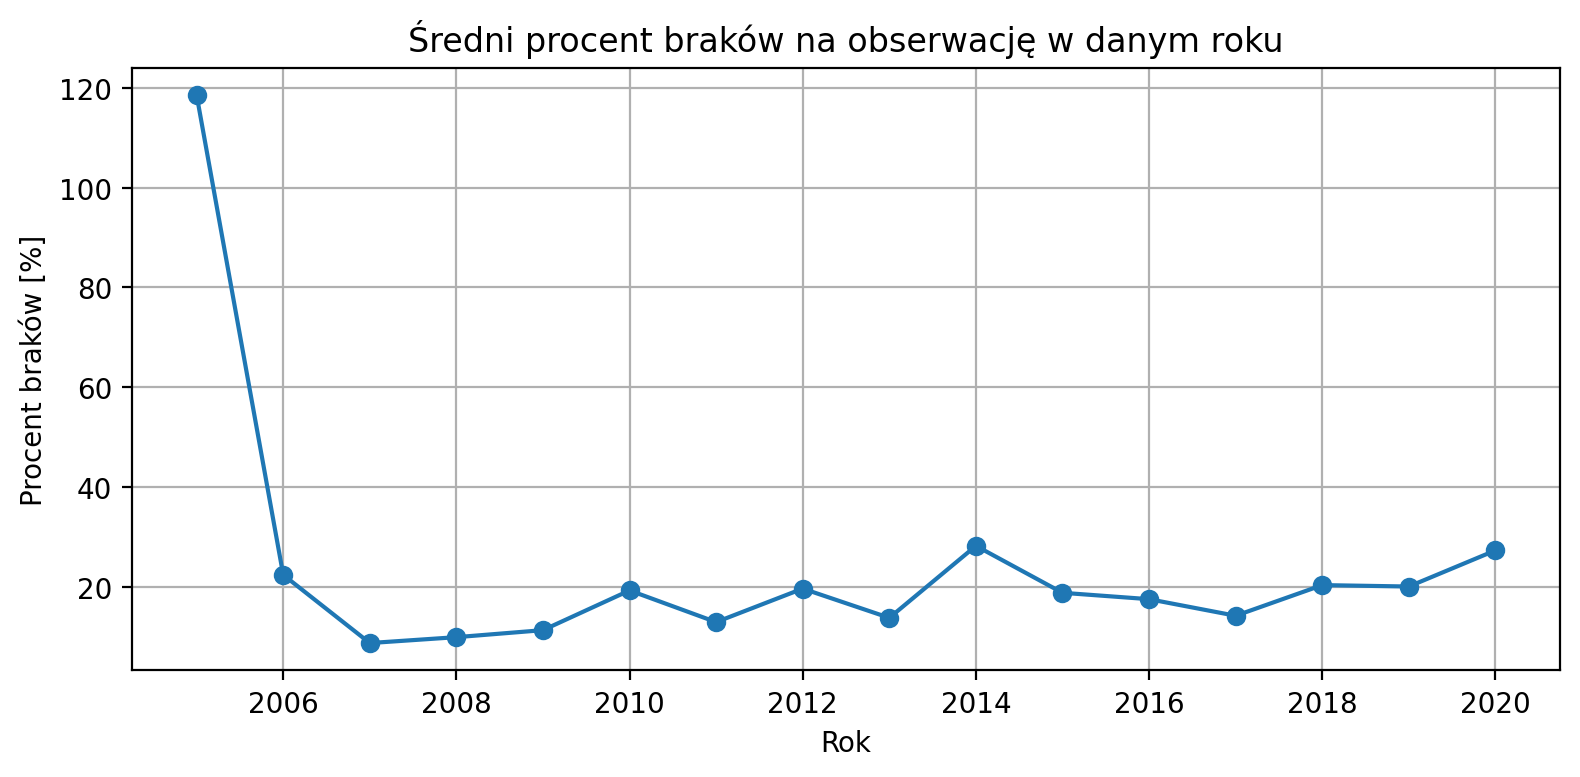

In [7]:
# Zliczenie liczby braków w każdej obserwacji
df['missing_per_row'] = df.isnull().sum(axis=1)

# Obliczenie średniej liczby braków na obserwację w danym roku
mean_missing_by_year = df.groupby('year')['missing_per_row'].mean()

# Obliczenie procentu braków w danym roku
percent_missing_by_year = df.groupby('year')['missing_per_row'].sum() / df.groupby('year').size() * 100

# Połączenie do jednego DataFrame
missing_summary = pd.DataFrame({
    'avg_missing_per_row': mean_missing_by_year,
    'percent_missing': percent_missing_by_year
}).reset_index()

plt.figure(figsize=(8, 4))
plt.plot(missing_summary['year'], missing_summary['percent_missing'], marker='o')
plt.title('Średni procent braków na obserwację w danym roku')
plt.xlabel('Rok')
plt.ylabel('Procent braków [%]')
plt.grid(True)
plt.tight_layout()
plt.show()


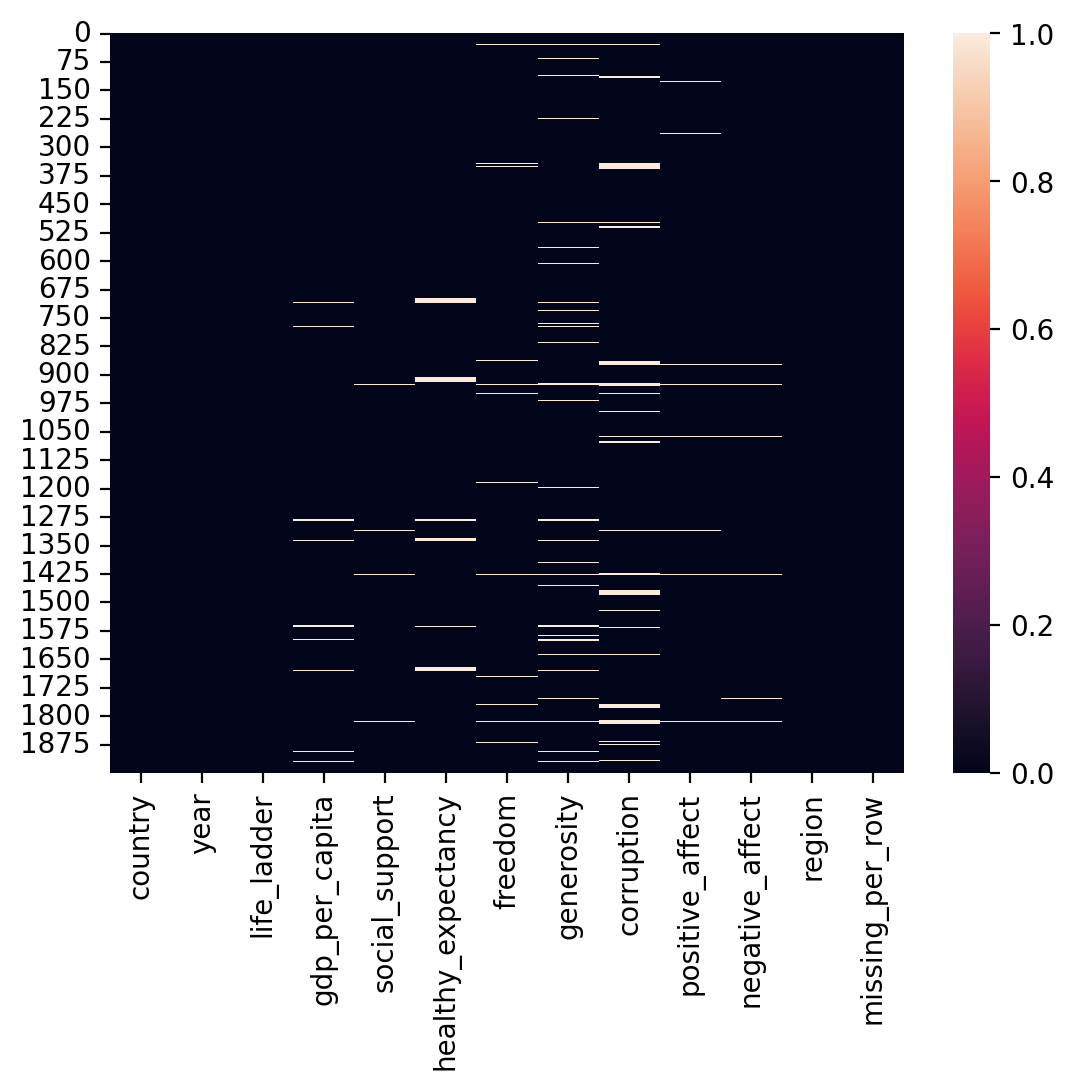

In [8]:
# sprawdzenie rozkładu braków w danych
sns.heatmap(df.isna());

In [9]:
# sprawdzam ile występuje obserwacji w obrębie regionów i lat
df.groupby(['region', 'year']).size().value_counts().sort_values(ascending=False)

2     27
8     14
5     13
7     10
1      9
29     9
20     8
19     8
21     7
17     6
4      6
15     5
10     3
6      3
35     3
18     3
26     3
3      3
16     3
9      2
36     2
22     2
28     2
23     2
11     2
25     1
32     1
34     1
14     1
13     1
Name: count, dtype: int64

Braki występują w 9 z 12 kolumn. Najwięcej braków zaobserwowano w kolumnie *corruption* (110), a także w **generosity**, **healthy_expectancy**, **gdp_per_capita** oraz **freedom**. Kolumny **country**, **year**, **life_ladder** oraz **region** są kompletne. Natomiast wykres prezentujący procentowy udział braków w danych w obrebie poszczególnych lat pokazuje, że rok 2005 znacznie odstaje odstaje pod względem kompletności danych. W 2005 roku na jedną obserwację przypadają średnio 1,18 braki. W pozostałych latach ilość ta nie przekracze 0,3. Z heatmapy prezentującej rozmieszczenie braków w danych można zauważyć, że braki nie są rozmieszczone równomiernie – ich skupiska pojawiają się w określonych obszarach (prawdopodobnie konkretnych latach lub regionach), co zostanie przeanalizowane w kolejnych krokach. Powyyższa tabela pokazuje, że w wielu regionach w poszczgólnych latach wystepuje bardzo mało obserwacji. W przypadku takich par region+rok imputacja braków będzie problematyczna.
<!-- Zauważono również, że w danych występują obserwacje z kilkoma pustymi wartościami w kolumnach. Zdecydowano o usunięciu takich, w których jest więcej niż 2, czyli dokładnie mniej niż 30 obserwacji. -->

In [10]:
# usuwam wiersze z brakującymi wartościami, gdzie jest więcej niż 2 brakujące wartości
# df = df.dropna(thresh=df.shape[1] - 2) 
# df.info()

<!-- TODO do edycji -->
W pierwszej kolejności poddano analizie kolumne 'corruption'.

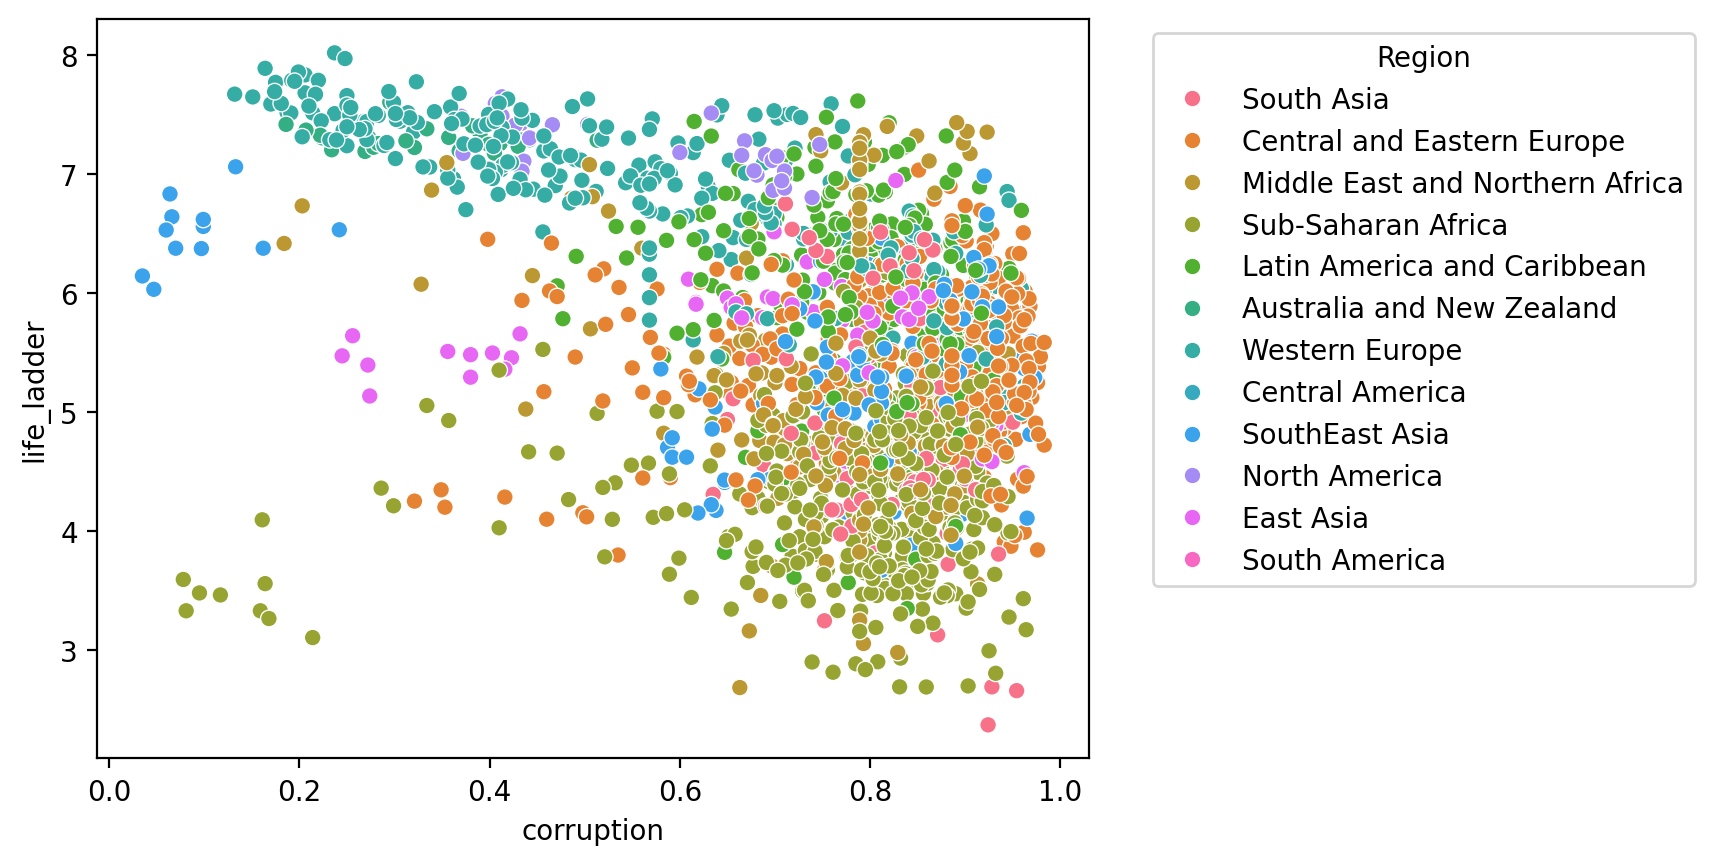

In [51]:
#sns.boxplot(data=df, y='corruption')

#df['corruption'].hist(bins=50)
#plt.yscale('log')

sns.scatterplot(data=df, x='corruption', y='life_ladder', hue='region')
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')


In [11]:
# braki w 'corruption' wg. lat
df[df['corruption'].isnull()]['year'].value_counts()

year
2016    11
2015    10
2017    10
2012    10
2014     9
2019     8
2018     8
2011     8
2013     7
2020     6
2006     6
2010     5
2007     4
2008     3
2009     3
2005     2
Name: count, dtype: int64

In [12]:
# braki w 'corruption' wg regionów
df[df['corruption'].isnull()]['region'].value_counts()

region
Middle East and Northern Africa    64
East Asia                          15
Central and Eastern Europe         12
SouthEast Asia                      8
Western Europe                      6
Sub-Saharan Africa                  4
Latin America and Caribbean         1
Name: count, dtype: int64

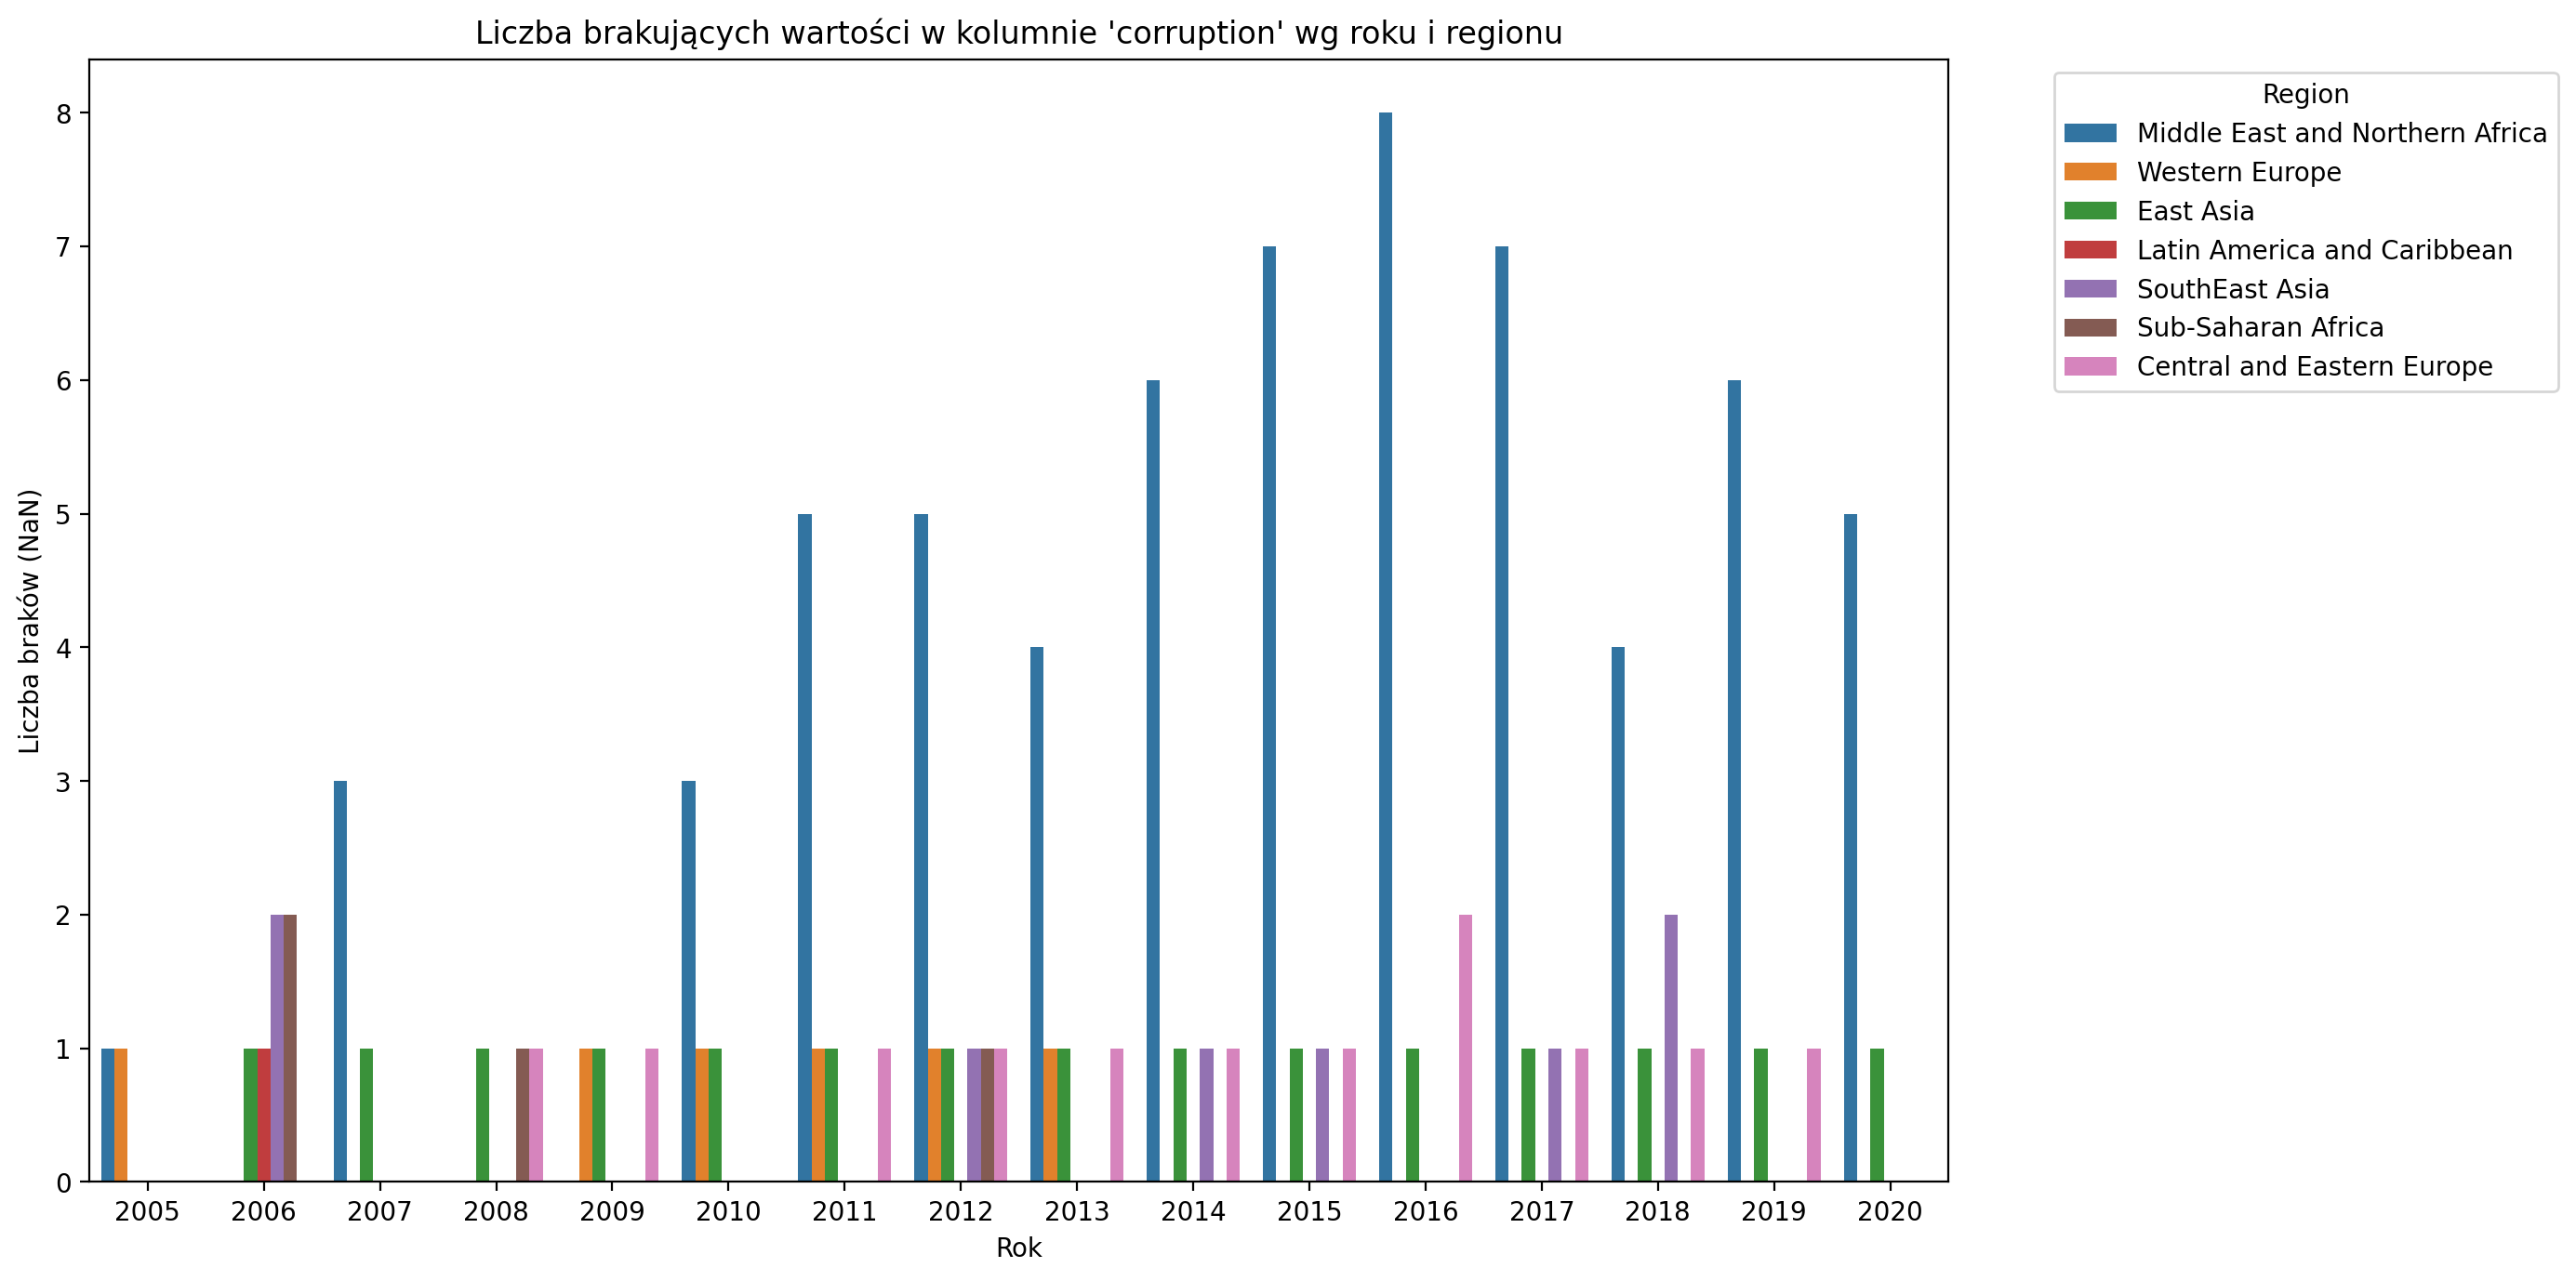

In [13]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'corruption'
missing_corr = df[df['corruption'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_corr_counts = missing_corr.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_corr_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'corruption' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO do edycji - może wyglądać lepiej -->
Braki danych w kolumnie 'corruption' rozkładają się w miarę równomiernie w latach, w których wystepuje najwięcej braków. Natomiast zdecydowanie najwięcej NaN wystepuje w regionie Middle East and Northern Africa. Mamy do czynienia z MAR (*Missing at random*). Wystapienie błedu zależy od regionu kraju. Postawowiono uzupełnić wartości medianą w każdego z regionów. Lata nie będą brały udziału w imputacji, ponieważ były by sytuacje, gdy mediana byłaby liczona czasem z niewielkiej liczby obserwacji.

In [14]:
# imputacja NaN w kolumnie 'corruption' medianą z regionów
df['corruption'] = df.groupby(['region'])['corruption'].transform(
    lambda x: x.fillna(x.median())
)
df['corruption'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *freedom*

In [15]:
# braki w 'freedom' wg. lat
df[df['freedom'].isnull()]['year'].value_counts().sort_values(ascending=False)


year
2014    7
2006    3
2015    3
2008    3
2016    2
2005    2
2010    2
2009    2
2007    1
2013    1
2012    1
2018    1
2019    1
2020    1
2011    1
2017    1
Name: count, dtype: int64

In [16]:
# braki w 'freedom' wg. regionów
df[df['freedom'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    12
Central and Eastern Europe          8
SouthEast Asia                      6
East Asia                           5
Sub-Saharan Africa                  1
Name: count, dtype: int64

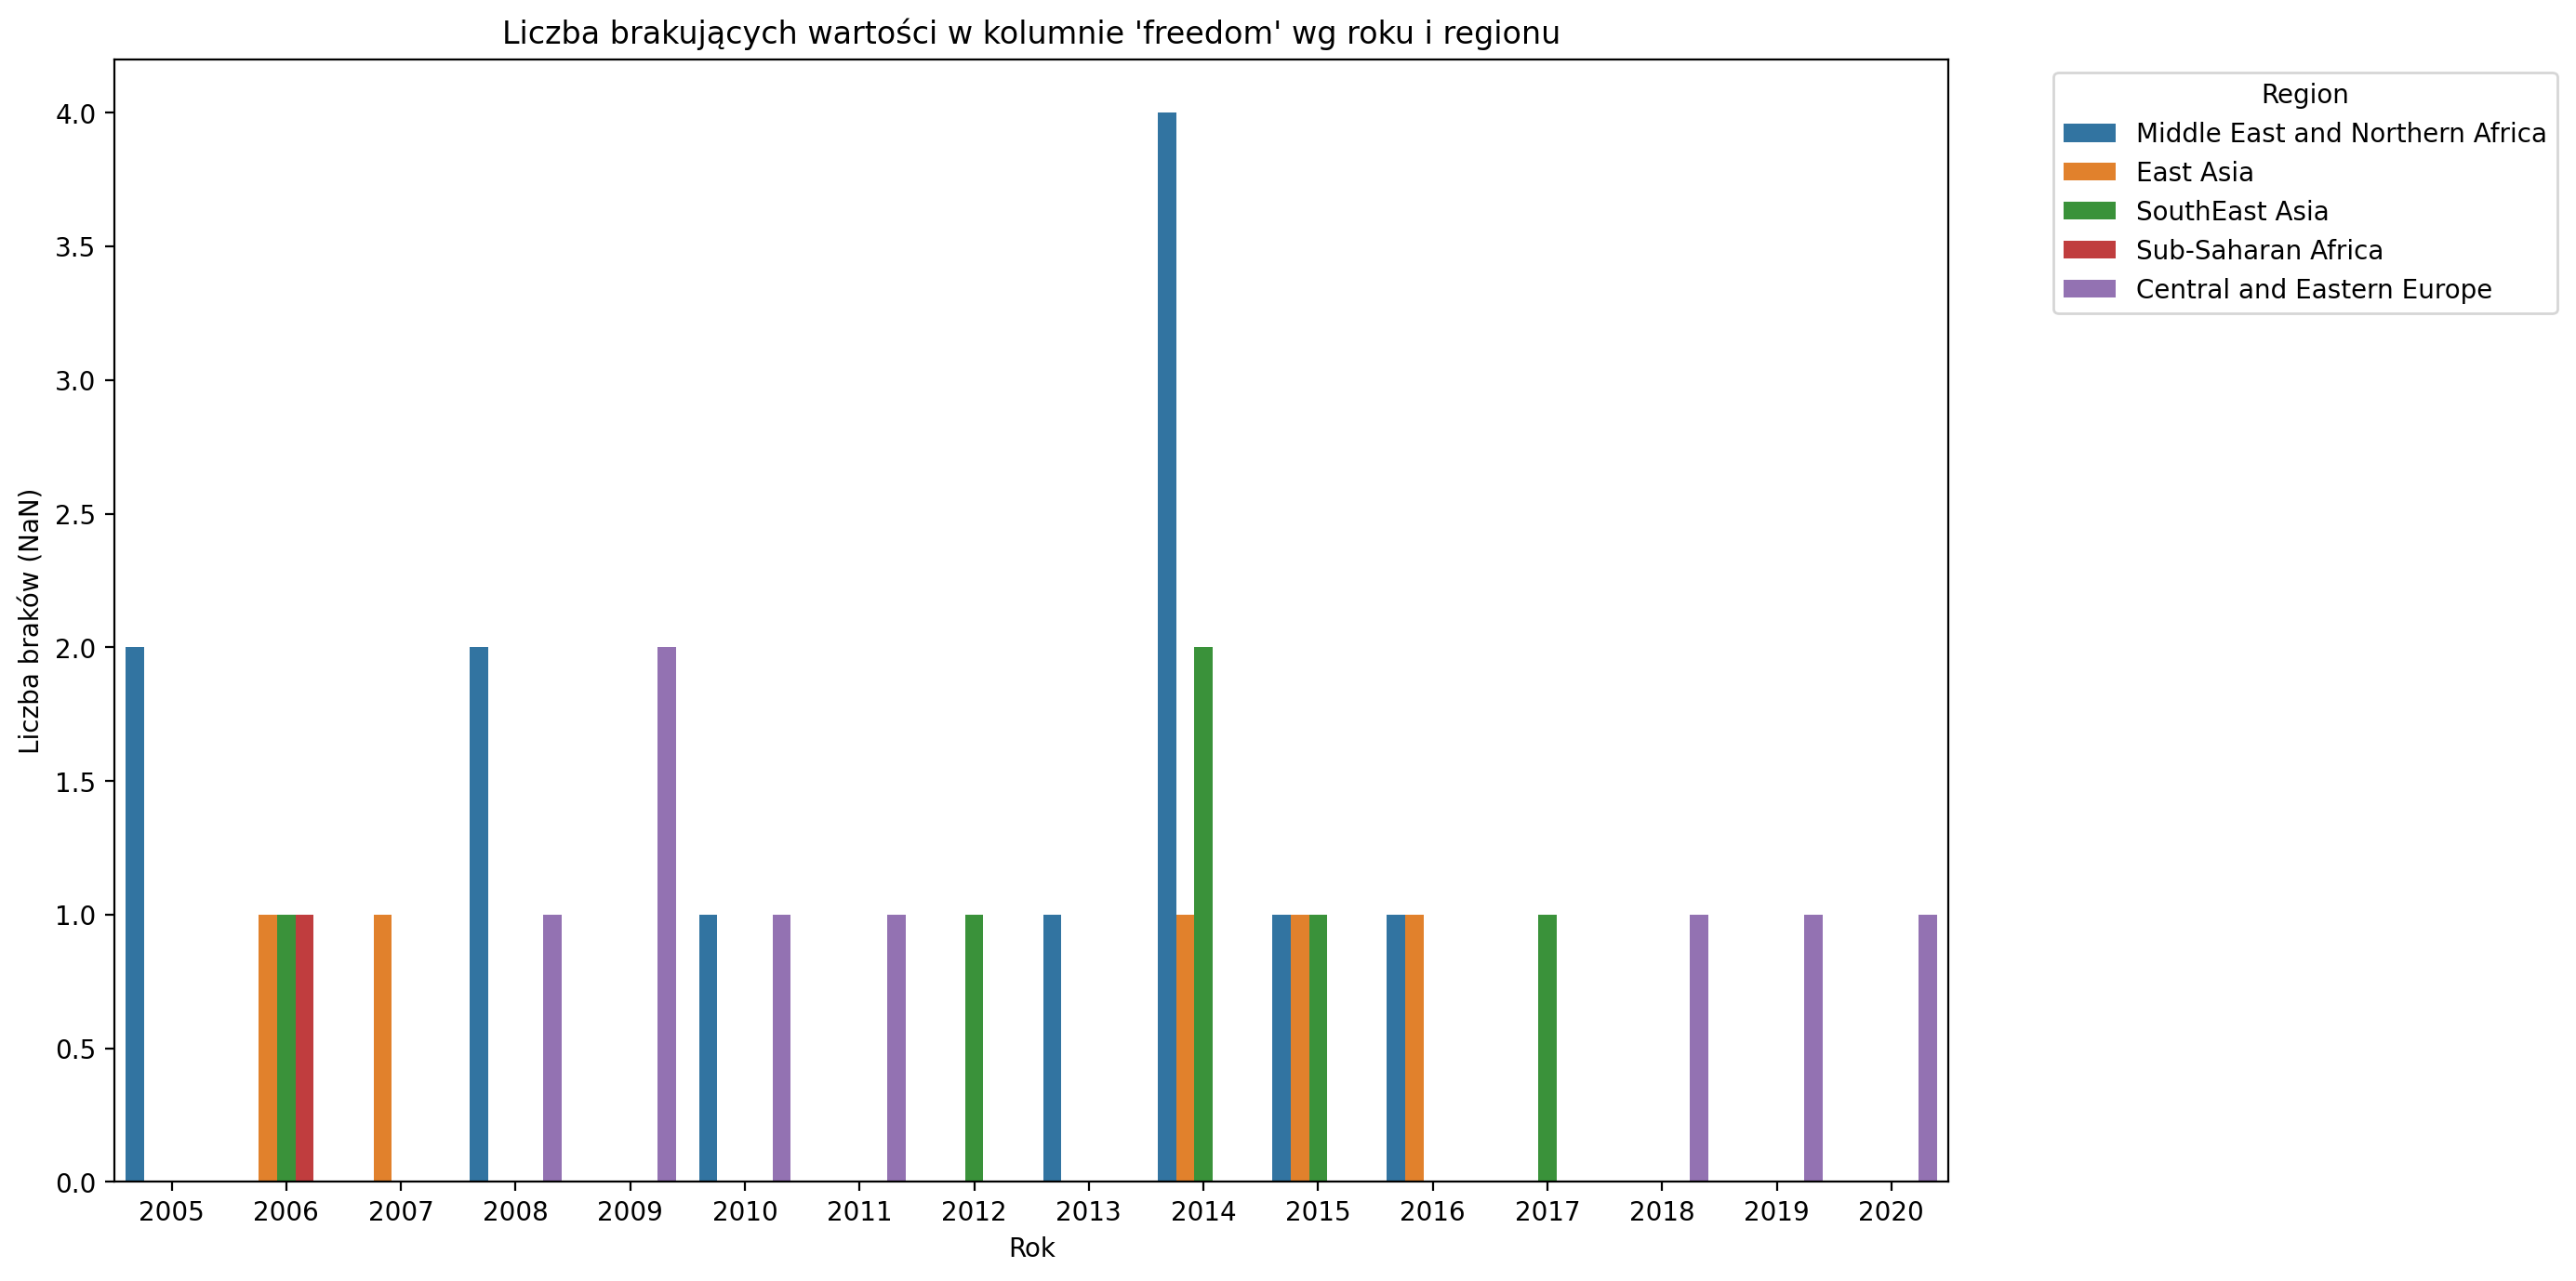

In [17]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'freedom'
missing_gen = df[df['freedom'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_gen_counts = missing_gen.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_gen_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'freedom' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO  przez przypadek 2x generosity zrobione. to trzeba przerobic na freedom Do edycji to i wszystkie markdowny poza jednym w sumie zrobionym porządnie -->
Kolumna *generosity* zawierała najwięcej braków w regionach *Middle East and Northern Africa* oraz *Western Europe*,. Równomiernie w latach -> zdecydowano się na imputację medianą w obrębie regionu. 

In [18]:
# imputacja NaN w kolumnie 'freedom' medianą z regionów
df['freedom'] = df.groupby(['region'])['freedom'].transform(
    lambda x: x.fillna(x.median())
)
df['freedom'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *healthy_expectancy*

In [19]:
# braki w 'healthy_expectancy' wg. lat
df[df['healthy_expectancy'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2012    6
2011    5
2014    5
2016    5
2019    5
2017    4
2013    4
2015    4
2018    4
2009    3
2010    3
2020    3
2008    2
2006    1
2007    1
Name: count, dtype: int64

In [20]:
# braki w 'healthy_expectancy' wg. regionów
df[df['healthy_expectancy'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Central and Eastern Europe         14
East Asia                          11
South Asia                         10
Middle East and Northern Africa     9
Western Europe                      7
Sub-Saharan Africa                  4
Name: count, dtype: int64

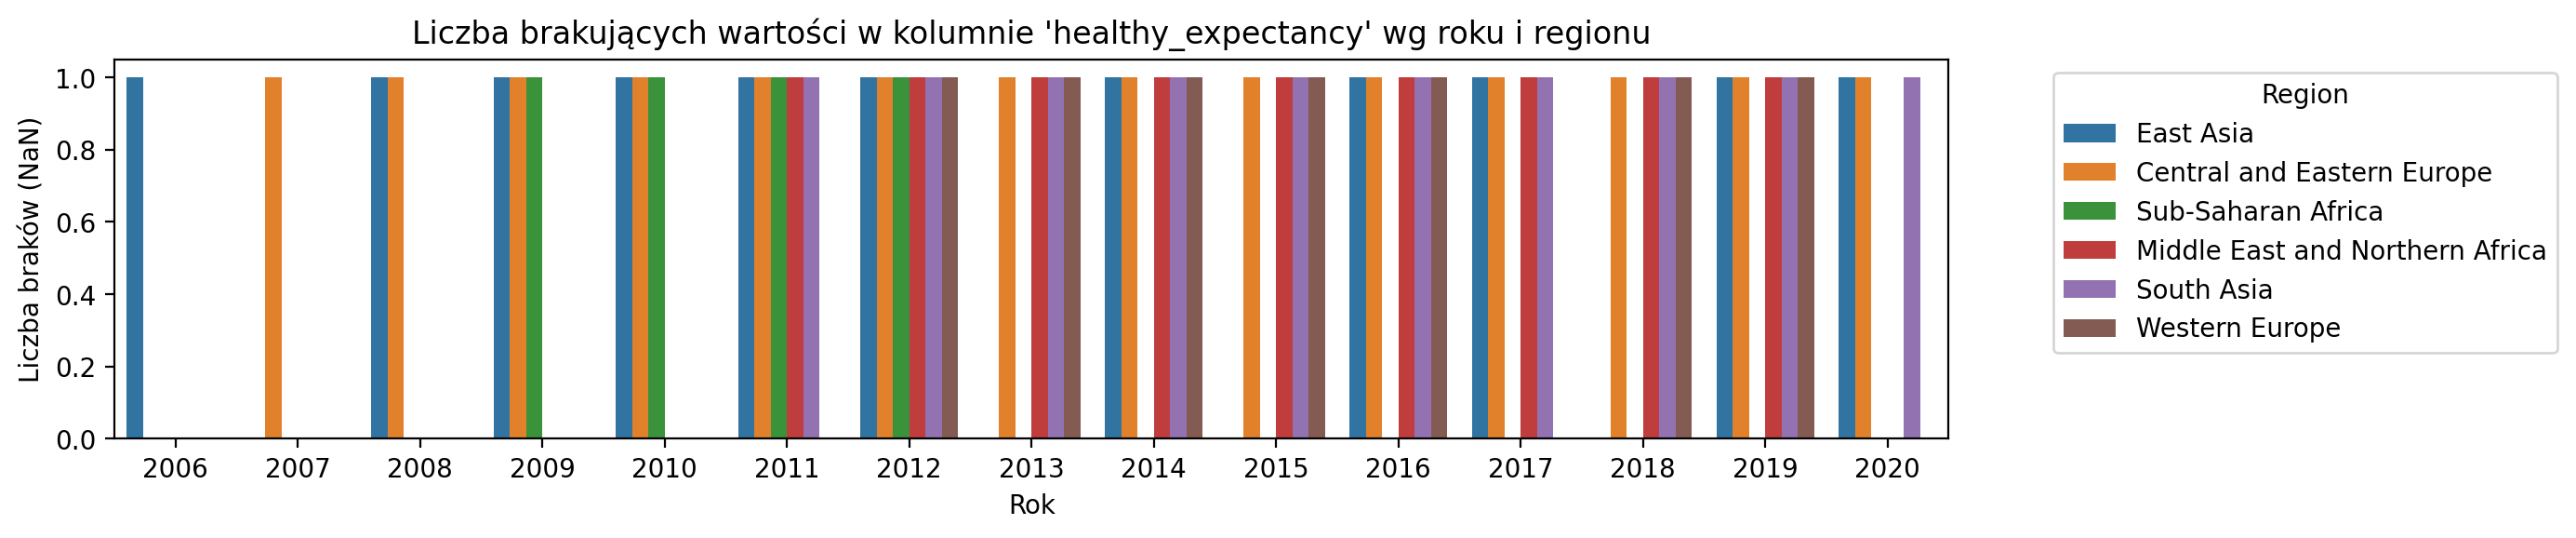

In [21]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'generosity'
missing_health = df[df['healthy_expectancy'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_health_counts = missing_health.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 3))
sns.barplot(data=missing_health_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'healthy_expectancy' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO do edycji -->
Kolumna *healthy_expectancy* zawierała braki w regionach *Middle East and Northern Africa*, *Central and Eastern Europe*, *East Asia* oraz *Southern Asia*. Żaden z poszczególnych roków nie wybija się ponad inne w ilości braków. Zdecydowano się na imputację medianą w obrębie regionu. 

In [22]:
# imputacja NaN w kolumnie 'healthy_expectancy' medianą z regionów
df['healthy_expectancy'] = df.groupby(['region'])['healthy_expectancy'].transform(
    lambda x: x.fillna(x.median())
)
df['healthy_expectancy'].isnull().sum()

0

<!-- TODO do edycji -->
Kolejno poddano analizie braki w kolumnie *generosity*

In [23]:
# braki w 'generosity' wg. lat
df[df['generosity'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2005    26
2012     9
2006     8
2014     7
2020     7
2019     7
2018     6
2016     4
2013     4
2015     4
2011     2
2017     2
2008     1
2009     1
2010     1
Name: count, dtype: int64

In [24]:
# braki w 'generosity' wg. regionów
df[df['generosity'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    29
Western Europe                     21
Sub-Saharan Africa                 12
Latin America and Caribbean         8
South Asia                          6
East Asia                           5
Central and Eastern Europe          5
Australia and New Zealand           1
North America                       1
SouthEast Asia                      1
Name: count, dtype: int64

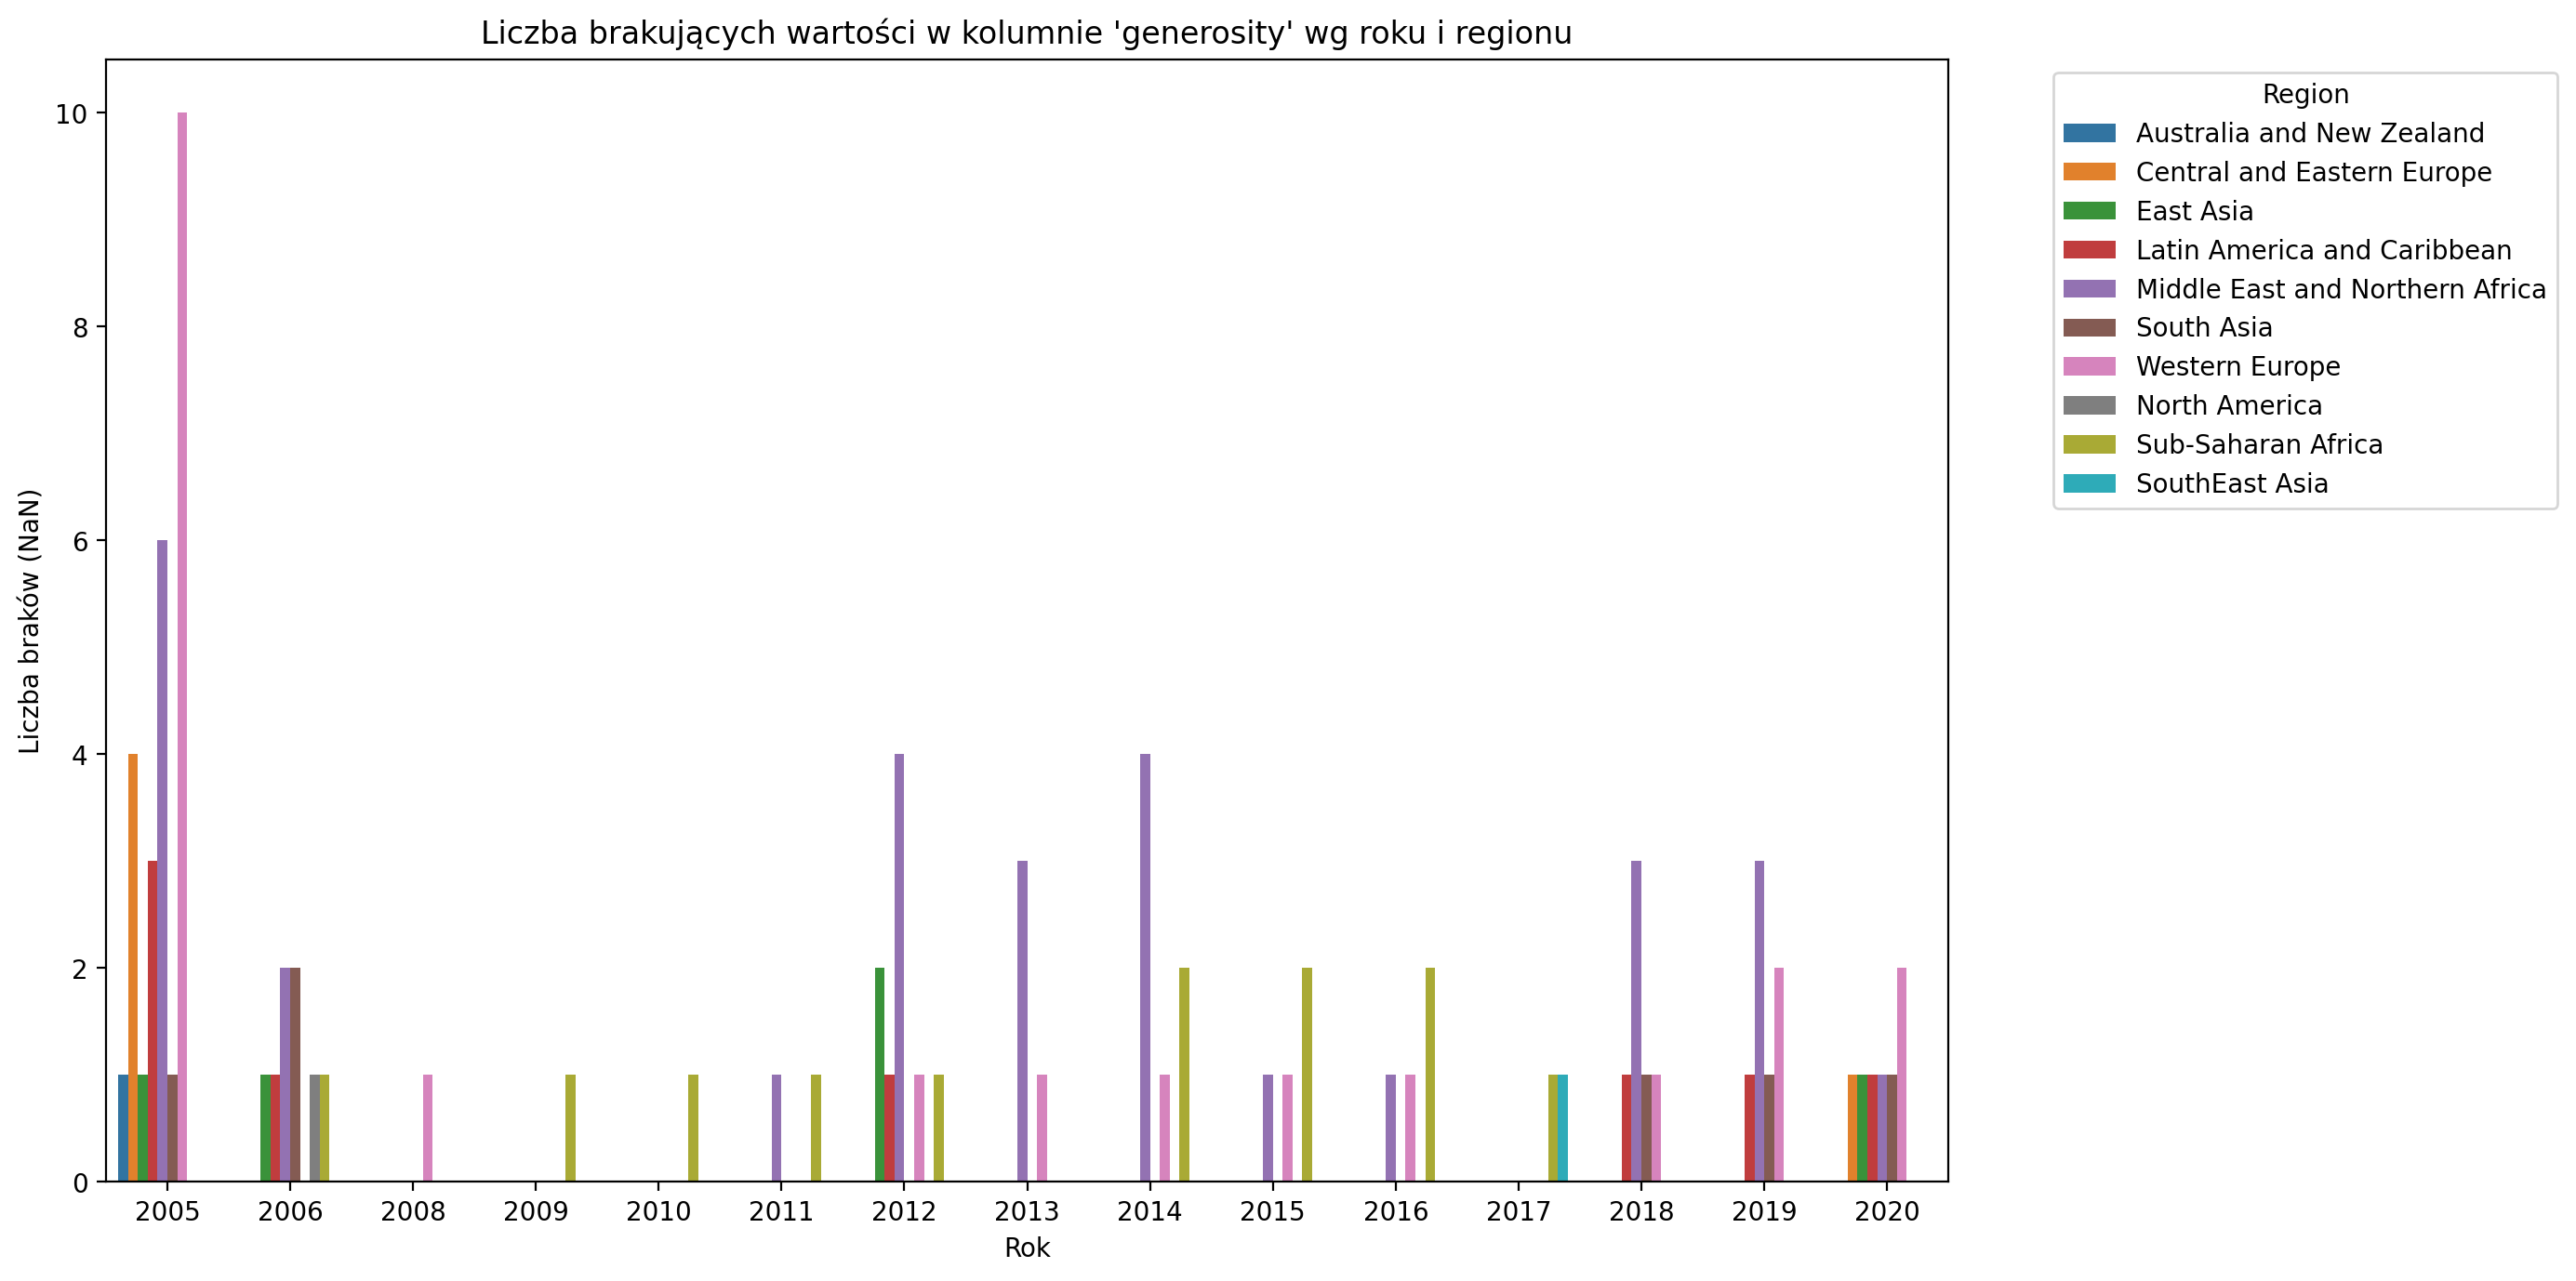

In [25]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'generosity'
missing_ger = df[df['generosity'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_ger_counts = missing_ger.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_ger_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'generosity' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
# sprawdzenie ile danych jest w 2005 roku w kolumnie 'generosity'
df_2005 = df[df['year'] == 2005]

# Liczenie braków i niebrakujących wartości w kolumnie 'generosity'
generosity_nulls = df_2005['generosity'].isnull().sum()
generosity_filled = df_2005['generosity'].notnull().sum()

# Tworzenie podsumowania
summary_2005 = pd.DataFrame({
    'Missing (NaN)': [generosity_nulls],
    'Filled (Not NaN)': [generosity_filled]
}, index=['generosity'])
summary_2005

,Missing (NaN),Filled (Not NaN)
generosity,26,1


<!-- TODO do edycji? -->
Kolumna *generosity* zawierała najwięcej braków w regionach *Western Europe* i *Middle East and Northern Africa*, a także wiele wystpąpiło w *Central and Eastern Europe* i *Latin America and Caribbean*. W podziale na poszczególne lata najwięcej braków pojawiło się w roku 2005. Natomiast w roku 2005 tylko jedna obserwacja posiadała dane. Zdecydowano przeprowadzić imputację medianą w zależności od regionu.

In [27]:
# imputacja NaN w kolumnie 'generosity' medianą z regionów
df['generosity'] = df.groupby(['region'])['generosity'].transform(
    lambda x: x.fillna(x.median())
)
df['generosity'].isnull().sum()

0

Kolejno poddano analizie braki w kolumnie *gdp_per_capita*

In [28]:
# braki w 'gdp_per_capita' wg. krajów
df[df['gdp_per_capita'].isnull()]['country'].value_counts().sort_values(ascending=False)

country
North Cyprus                 7
Somaliland region            4
South Sudan                  4
Iran                         3
Somalia                      3
Taiwan Province of China     3
Venezuela                    3
Palestinian Territories      2
Yemen                        2
Cuba                         1
Cyprus                       1
Hong Kong S.A.R. of China    1
Kosovo                       1
Malta                        1
Name: count, dtype: int64

In [29]:
# braki w 'gdp_per_capita' wg. lat
df[df['gdp_per_capita'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2020    7
2018    6
2019    6
2014    3
2015    3
2016    3
2012    2
2006    1
2013    1
2009    1
2010    1
2011    1
2017    1
Name: count, dtype: int64

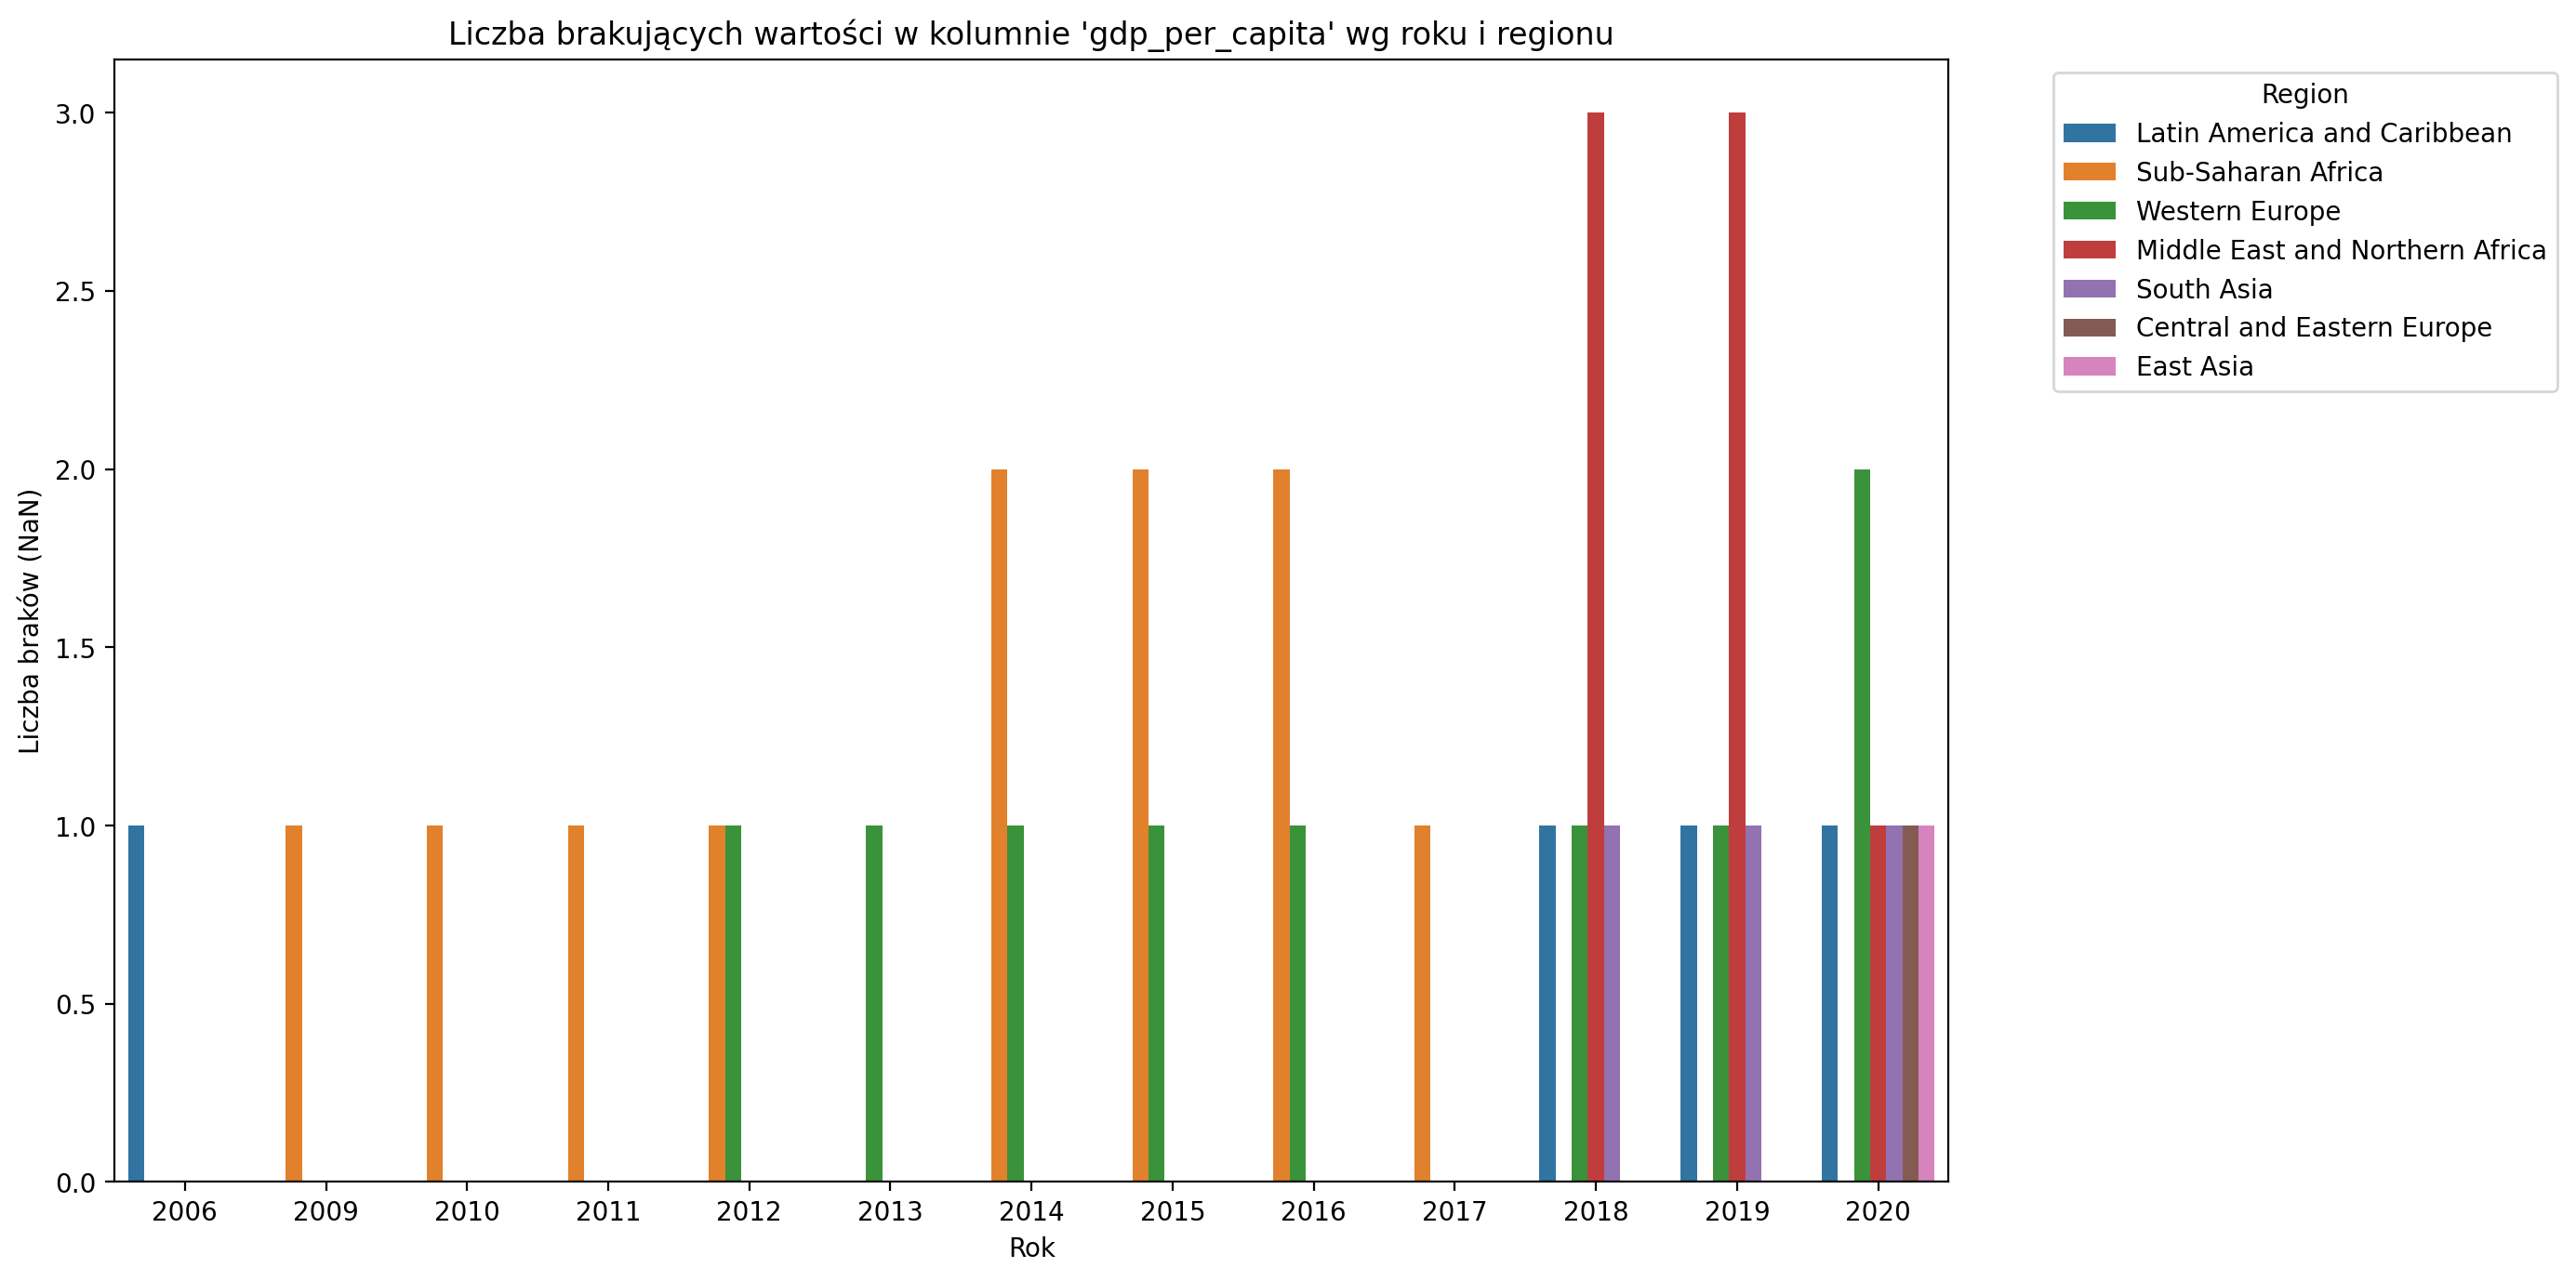

In [30]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'gdp_per_capita'
missing_gdp = df[df['gdp_per_capita'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_gdp_counts = missing_gdp.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_gdp_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'gdp_per_capita' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Imputacja brakujących wartości w kolumnie `gdp_per_capita`

W kolumnie `gdp_per_capita` (PKB per capita) stwierdzono obecność braków danych. Ze względu na charakter tej zmiennej — makroekonomicznej i odnoszącej się do konkretnego kraju i roku — wartości te powinny być identyczne dla wszystkich obserwacji odpowiadających danemu krajowi w danym roku.

Przeprowadzono analizę rozkładu braków względem lat i regionów. Występowanie braków było nierównomierne, co wyklucza przypadkowość (MCAR). Braki występowały częściej w mniej rozwiniętych regionach i w starszych rocznikach, co może wskazywać na mechanizm MAR (ang. *Missing At Random*).

Aby zachować spójność danych i nie zniekształcać rozkładu PKB w analizie, zastosowano **wielopoziomową strategię imputacji**:

1. W pierwszej kolejności uzupełniono braki medianą `gdp_per_capita` dla danego kraju i roku.
2. Jeśli brakowało danych dla konkretnego roku, wykorzystano średnią `gdp_per_capita` danego kraju z roku następnego i poprzedniego.
3. W kolejnym kroku wartość wyestymowano przy użyciu regresji liniowej na podstawie `gdp_per_capita` kraju w innych latach. 
4. W ostateczności, jeżeli kraj nie miał żadnych danych w innych latach, zastosowano medianę dla regionu i roku.

Taka strategia pozwala na uzupełnienie wszystkich braków w sposób maksymalnie dopasowany do kontekstu geograficzno-czasowego, a jednocześnie ogranicza ryzyko wprowadzenia zniekształceń do dalszej analizy.


In [31]:
# TODO tutaj chyba coś się pierdoli u lata wycina do sprawdzenia
# Kopia ramki danych
df_filled = df.copy()

# 1. Mediana dla country + year
gdp_country_year = df.groupby(['country', 'year'])['gdp_per_capita'].median()

# 2. Średnia z roku poprzedniego i następnego
def interpolate_gdp(row):
    country = row['country']
    year = row['year']
    
    prev_val = gdp_country_year.get((country, year - 1), np.nan)
    next_val = gdp_country_year.get((country, year + 1), np.nan)
    
    if not pd.isna(prev_val) and not pd.isna(next_val):
        return (prev_val + next_val) / 2
    return np.nan

# 3. Estymacja na podstawie trendu liniowego dla kraju
def estimate_from_trend(row):
    country = row['country']
    year = row['year']
    
    country_data = df[~df['gdp_per_capita'].isnull() & (df['country'] == country)]
    if country_data.empty or len(country_data['year'].unique()) < 2:
        return np.nan
    
    x = country_data['year']
    y = country_data['gdp_per_capita']
    a, b = np.polyfit(x, y, deg=1)
    return a * year + b

# 4. Mediana dla regionu + year
gdp_region_year = df.groupby(['region', 'year'])['gdp_per_capita'].median()

# Krok 1
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(
    lambda row: gdp_country_year.get((row['country'], row['year']), np.nan),
    axis=1
)

# Krok 2
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(interpolate_gdp, axis=1)

# Krok 3
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(estimate_from_trend, axis=1)

# Krok 4
mask = df_filled['gdp_per_capita'].isnull()
df_filled.loc[mask, 'gdp_per_capita'] = df_filled.loc[mask].apply(
    lambda row: gdp_region_year.get((row['region'], row['year']), np.nan),
    axis=1
)

# Przypisanie uzupełnionej kolumny do oryginalnego dataframe
df['gdp_per_capita'] = df_filled['gdp_per_capita']

# Sprawdzenie końcowej liczby braków w df
df['gdp_per_capita'].isnull().sum()

0

<!-- TODO napisać -->
następna *social_support*

In [32]:
# braki w 'social_support' wg. krajów
df[df['social_support'].isnull()]['region'].value_counts().sort_values(ascending=False)

region
Middle East and Northern Africa    9
North America                      2
Sub-Saharan Africa                 1
SouthEast Asia                     1
Name: count, dtype: int64

In [33]:
# braki w 'social_support' wg. lat
df[df['social_support'].isnull()]['year'].value_counts().sort_values(ascending=False)

year
2010    4
2014    3
2007    2
2011    1
2015    1
2009    1
2017    1
Name: count, dtype: int64

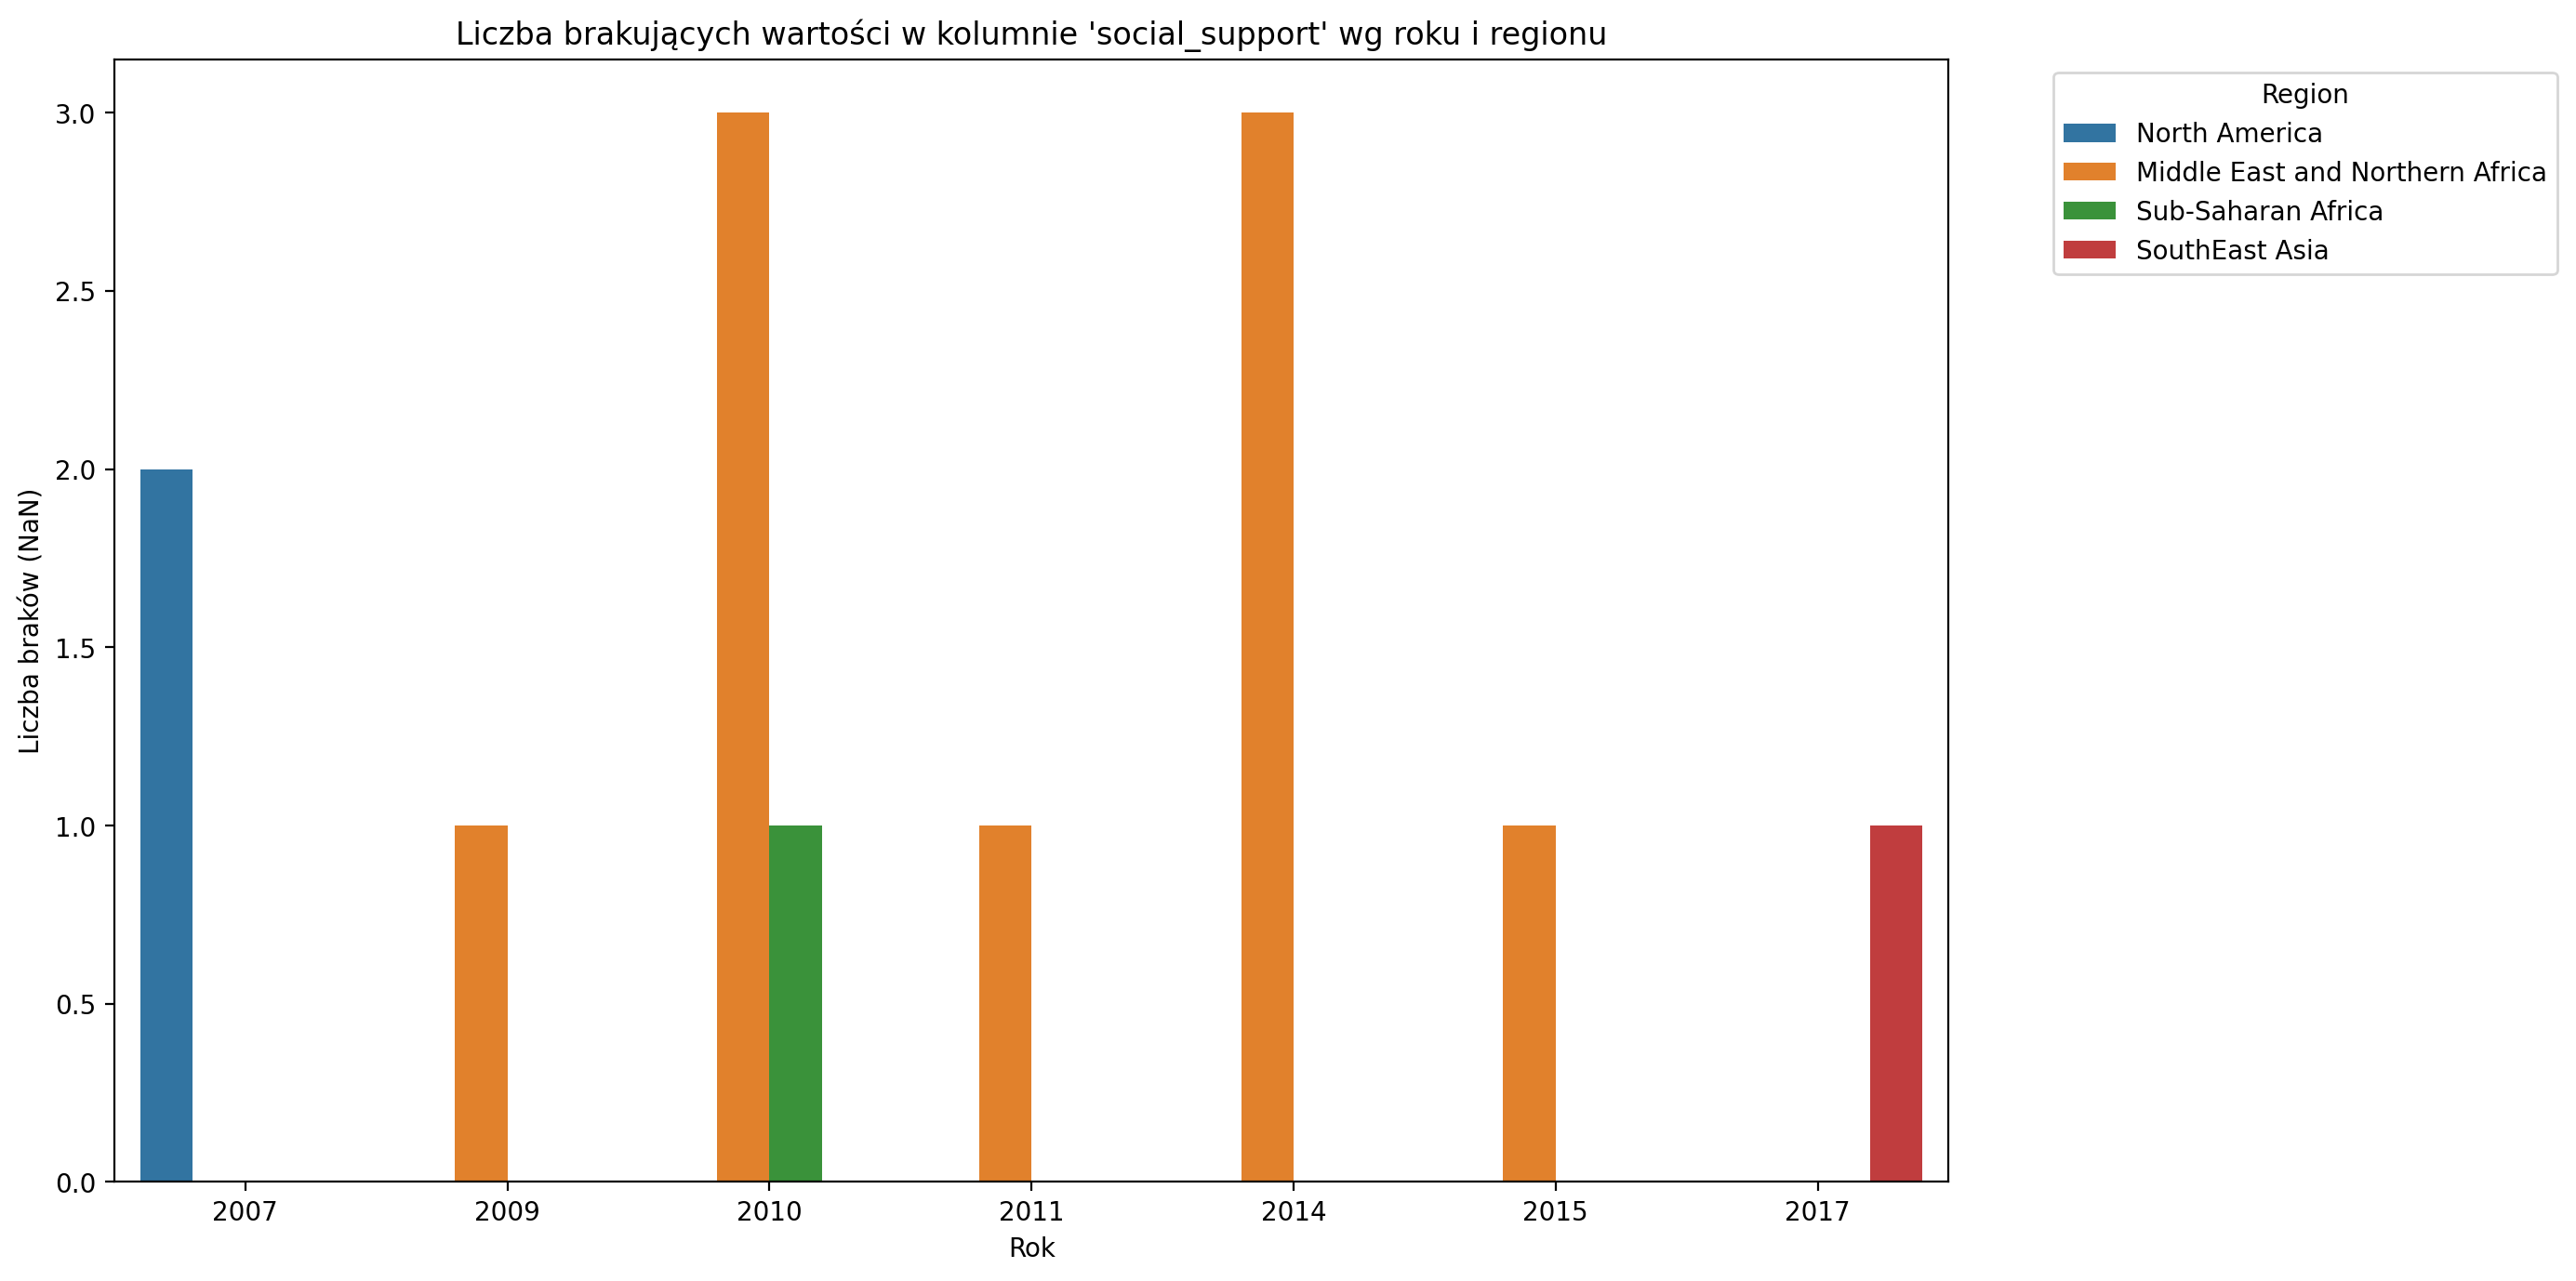

In [34]:
# Filtrowanie tylko obserwacji z brakującą wartością w 'gdp_per_capita'
missing_soc = df[df['social_support'].isnull()]

# Grupowanie i zliczanie braków według roku i regionu
missing_soc_counts = missing_soc.groupby(['year', 'region']).size().reset_index(name='NaN_count')

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
sns.barplot(data=missing_soc_counts, x='year', y='NaN_count', hue='region')
plt.title("Liczba brakujących wartości w kolumnie 'social_support' wg roku i regionu")
plt.xlabel("Rok")
plt.ylabel("Liczba braków (NaN)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<!-- TODO napisać -->
*social_support* lata równomiernie, region się wybija Middle East and Northern Africa

In [35]:
# imputacja NaN w kolumnie 'generosity' medianą z regionów
df['social_support'] = df.groupby(['region'])['social_support'].transform(
    lambda x: x.fillna(x.median())
)
df['social_support'].isnull().sum()

0

In [36]:
# do savowania danych
df_cleaned = df
df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)
df_cleaned.isnull().sum()

country                0
year                   0
life_ladder            0
gdp_per_capita         0
social_support         0
healthy_expectancy     0
freedom                0
generosity             0
corruption             0
positive_affect       22
negative_affect       16
region                 0
missing_per_row        0
dtype: int64

In [37]:
# do testów

# Zliczanie braków w każdej kolumnie, pogrupowane po roku i regionie
missing_summary = df.groupby(['year', 'region']).apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_missing')

missing_summary[missing_summary['year']==2005].sort_values(by='total_missing', ascending=False)

,year,region,total_missing
4,2005,Middle East and Northern Africa,1
6,2005,South Asia,1
0,2005,Australia and New Zealand,0
1,2005,Central and Eastern Europe,0
2,2005,East Asia,0
3,2005,Latin America and Caribbean,0
5,2005,North America,0
7,2005,Western Europe,0


In [38]:
# do wywalenia
df.groupby(['region', 'year']).size().value_counts().sort_values()

13     1
34     1
32     1
25     1
14     1
11     2
23     2
28     2
22     2
36     2
9      2
10     3
6      3
35     3
18     3
26     3
16     3
3      3
15     5
4      6
17     6
21     7
19     8
20     8
29     9
1      9
7     10
5     13
8     14
2     27
Name: count, dtype: int64

In [39]:
# do testów - wywalenia
# wszystkie braki sumarycznie dla poszczególnych krajów
df[df.isnull().any(axis=1)]['country'].value_counts()
missing_by_country = df.groupby('country').apply(lambda x: x.isnull().sum().sum()).sort_values(ascending=False)
print(missing_by_country.head(10))

country
Jordan                  6
Qatar                   4
United Arab Emirates    3
Algeria                 2
Maldives                2
Vietnam                 2
Morocco                 2
Bahrain                 2
Tunisia                 2
Kuwait                  2
dtype: int64


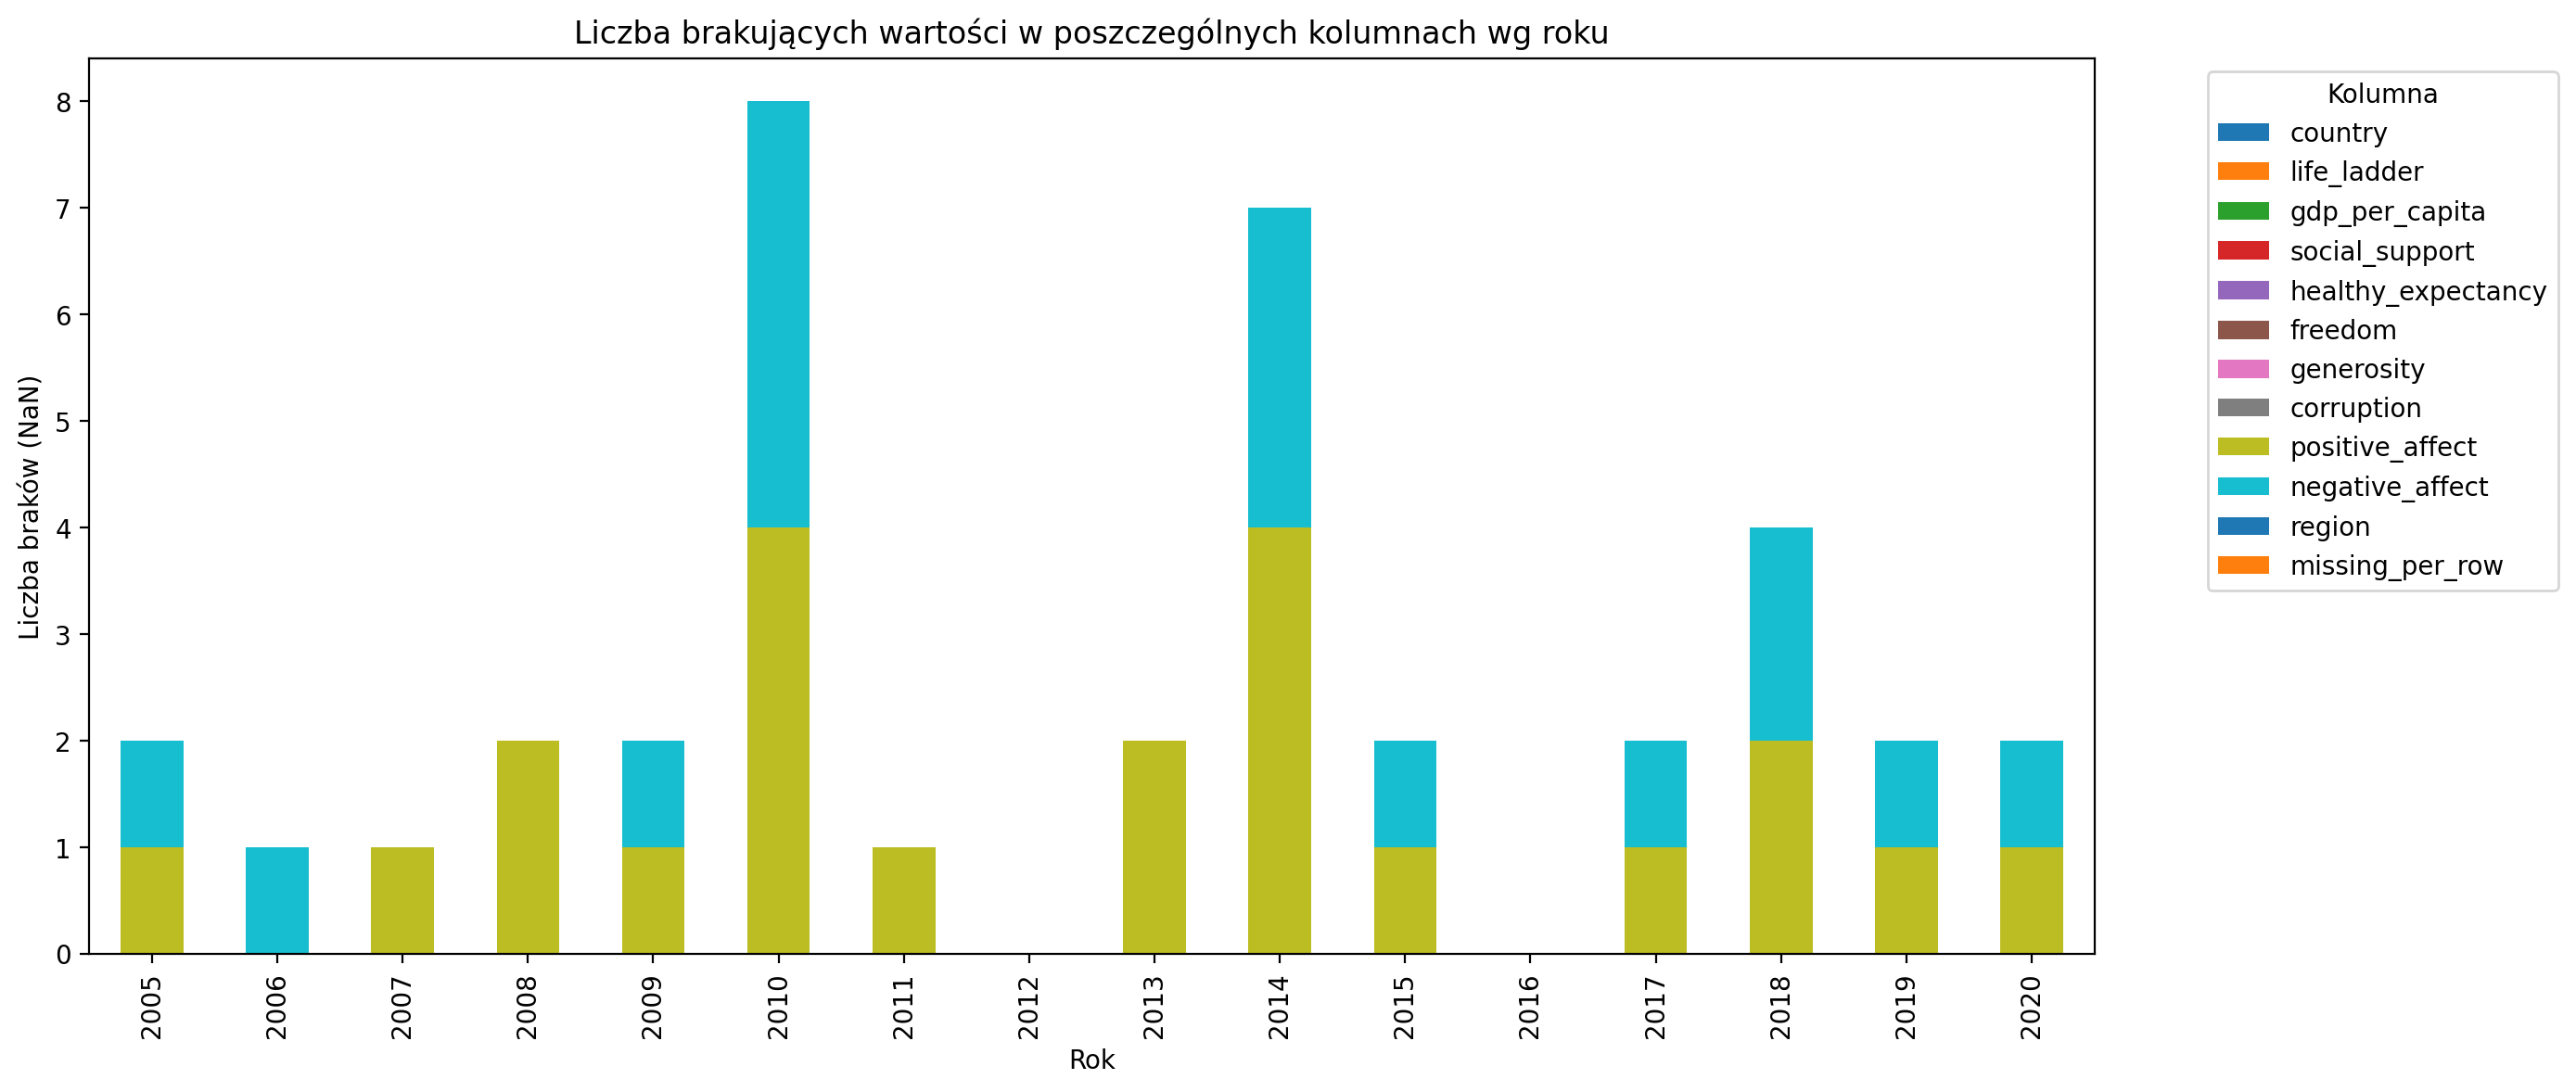

In [40]:
# do testów - wywalenia
# Tworzymy tabelę: liczba braków (NaN) w każdej kolumnie dla każdego roku
missing_by_year_col = df.groupby('year').apply(lambda g: g.isnull().sum()).drop(columns=['year'])

# Wykres słupkowy: lata na osi X, kolumny z brakami jako różne kolory
missing_by_year_col.plot(kind='bar', stacked=True, figsize=(14, 6))

plt.title('Liczba brakujących wartości w poszczególnych kolumnach wg roku')
plt.ylabel('Liczba braków (NaN)')
plt.xlabel('Rok')
plt.legend(title='Kolumna', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: >

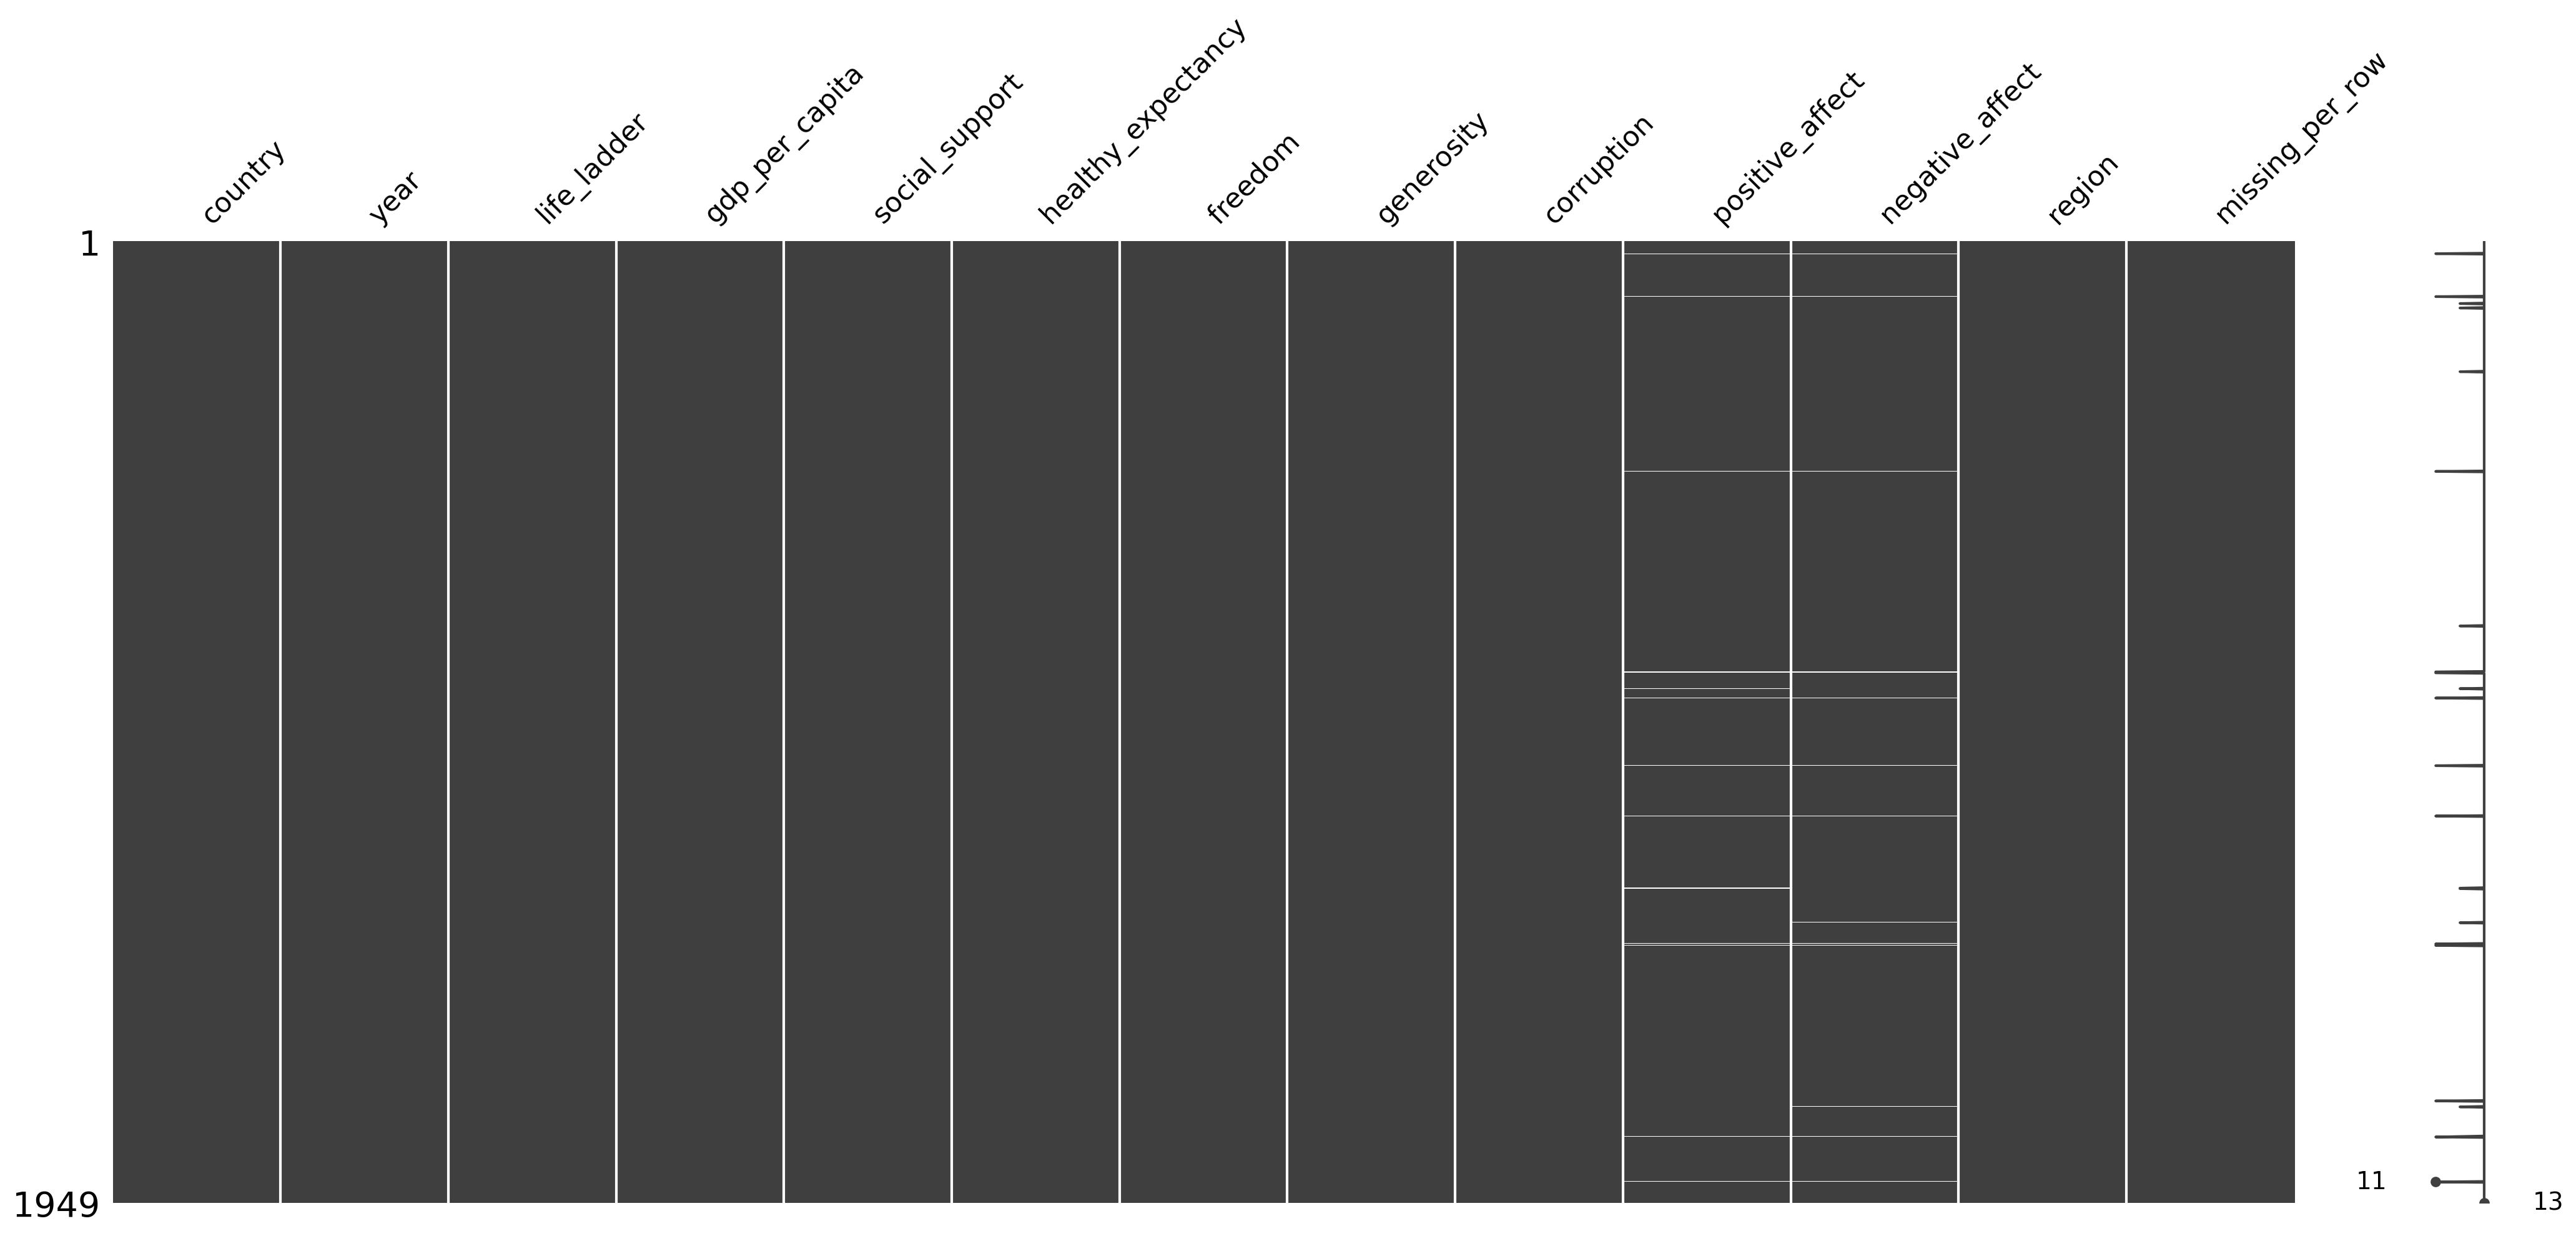

In [41]:
# do testów - wywalenia
import missingno as msno
msno.matrix(df)

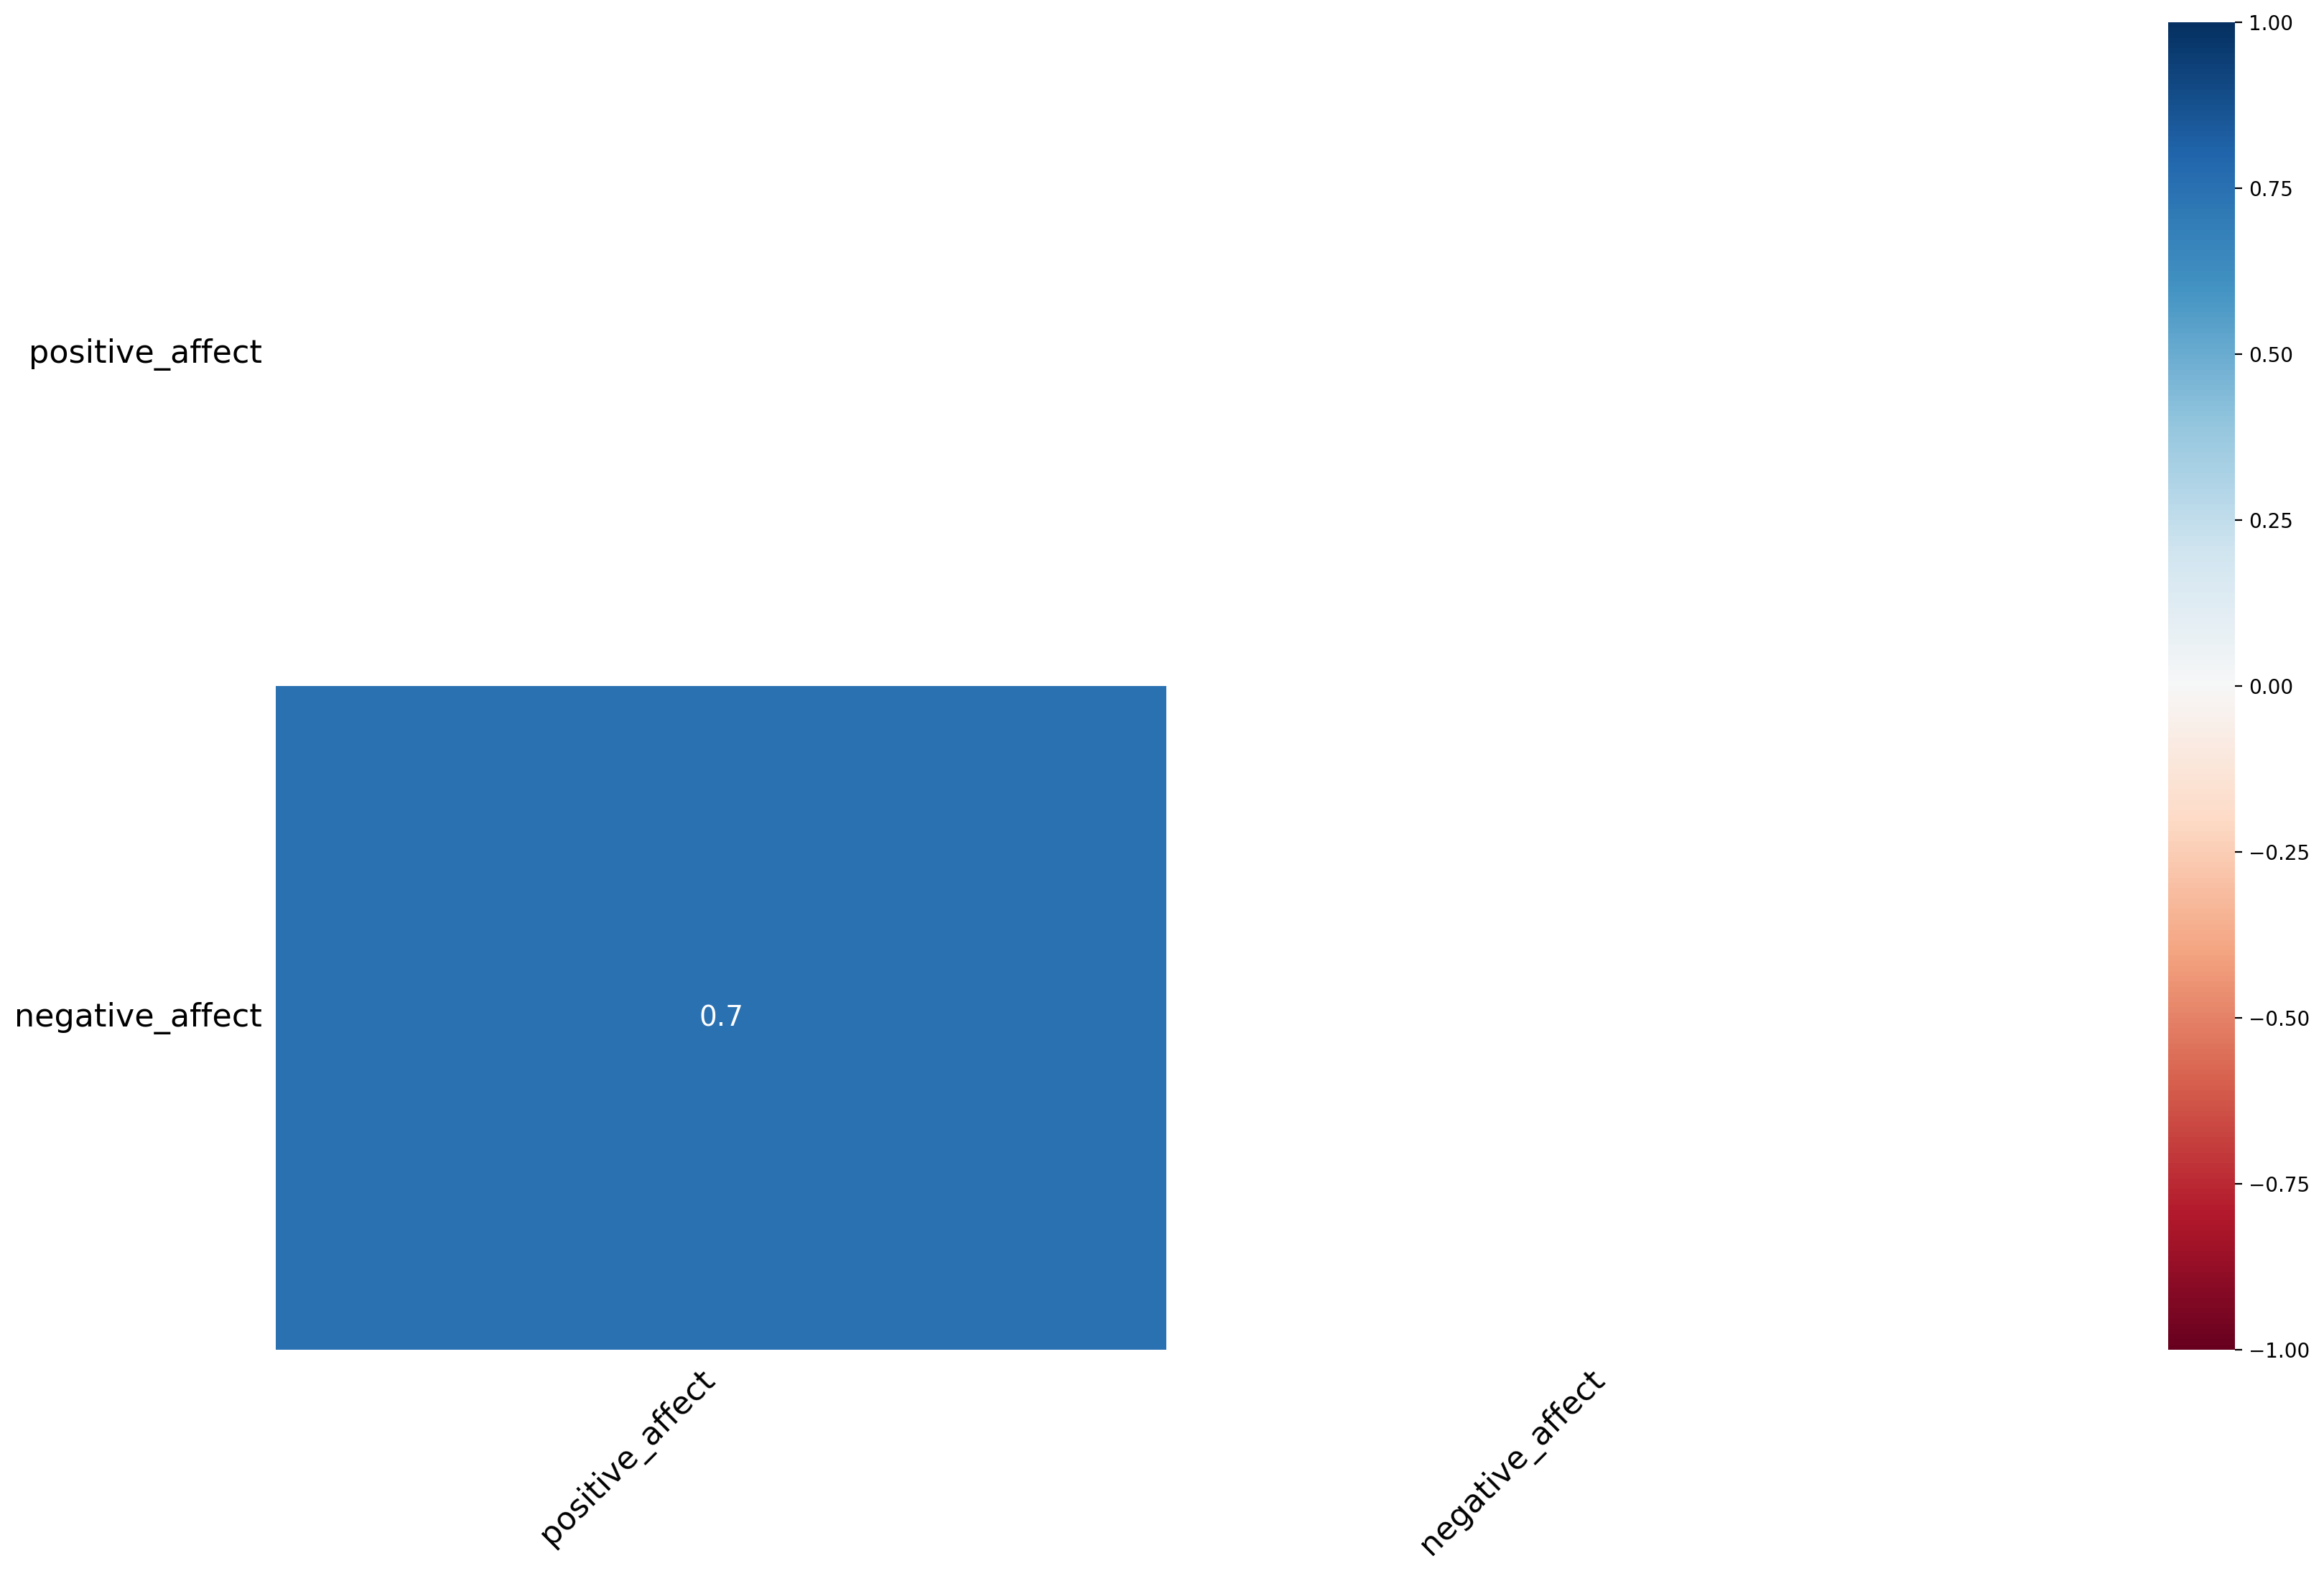

In [42]:
# do testów - wywalenia?
msno.heatmap(df);

In [43]:
# zapisuje oczyszczony DataFrame do pliku CSV
df_cleaned = df
df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)